In [31]:
import os
import pandas as pd
from tqdm import tqdm

class HousingData:
    def __init__(self, directory):
        self.directory = directory

    def remove_unwanted_columns_and_fill_na(self, df):
        unwanted_columns = [
            'Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1',
            'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1'
        ]
        df = df.drop(columns=unwanted_columns, errors='ignore')
        return df

    def load_data(self, state=None, city=None, property_type=None):
        dataframes = []
        for st in self._get_subdirectories(self.directory) if state is None else [state]:
            for ct in self._get_subdirectories(os.path.join(self.directory, st)) if city is None else [city]:
                for pt in self._get_subdirectories(os.path.join(self.directory, st, ct)) if property_type is None else [property_type]:
                    file_path = os.path.join(self.directory, st, ct, pt, 'forecasted_dataset.csv')
                    if os.path.exists(file_path):
                        df = pd.read_csv(file_path, parse_dates=['period_begin'])
                        df = self.remove_unwanted_columns_and_fill_na(df)
                        df['State'] = st
                        df['City'] = ct
                        df['Property_Type'] = pt
                        dataframes.append(df)
        all_data = pd.concat(dataframes, ignore_index=True)
        return self.remove_outliers(all_data)

    def load_cleansed_data(self):
        all_data = pd.read_csv('all_data.csv', parse_dates=['period_begin'])
        all_data = self.remove_unwanted_columns_and_fill_na(all_data)
        # Exclude 'Auburn' city and 'All Residential' property types
        all_data = all_data[(all_data['City'] != 'Auburn') & (all_data['Property_Type'] != 'All Residential')]
        return all_data


    def remove_outliers(self, df):
        def calculate_zero_proportion(df, column, city):
            city_data = df[df['City'] == city]
            zero_count = (city_data[column] == 0).sum()
            total_count = city_data.shape[0]
            return zero_count / total_count if total_count > 0 else 0

        # Property types to exclude from outlier removal
        exclude_property_types = ['Office', 'Industrial', 'Mall']

        # Calculate zero proportions for major cities as a baseline
        major_cities = ["New York", "Los Angeles", "Chicago", "Houston", "Phoenix", 
                    "Philadelphia", "San Antonio", "San Diego", "Dallas", "San Jose", 'San Francisco']
        major_cities_zero_proportions = [calculate_zero_proportion(df, 'asset_value_momentum', city) for city in major_cities]
        threshold = max(major_cities_zero_proportions) * 1.5  # Setting threshold as 150% of the max proportion in major cities

        # Identify cities to keep for each property type
        cities_to_keep = {}
        for property_type in tqdm(df['Property_Type'].unique(), desc='Removing Outliers'):
            if property_type not in exclude_property_types:
                cities_to_keep[property_type] = []
                for city in df[df['Property_Type'] == property_type]['City'].unique():
                    city_zero_proportion = calculate_zero_proportion(df[df['Property_Type'] == property_type], 'asset_value_momentum', city)
                    if city_zero_proportion <= threshold or city in major_cities:
                        cities_to_keep[property_type].append(city)

        # Find the intersection (common cities) across all included property types
        common_cities = set.intersection(*[set(cities) for cities in cities_to_keep.values()])

        # Filter the DataFrame to include only common cities for included property types and all cities for excluded types
        df_cleaned = df[(df['Property_Type'].isin(exclude_property_types)) | (df['City'].isin(common_cities))]

        return df_cleaned



    def aggregate_data_by_property(self, state, city):
        city_path = os.path.join(self.directory, state, city)
        return self._aggregate_data(city_path, group_by=['Property_Type', 'period_begin'])

    def aggregate_data_across_cities(self, states, property_type):
        dataframes = []
        for state in states:
            state_path = os.path.join(self.directory, state)
            for city in self._get_subdirectories(state_path):
                file_path = os.path.join(state_path, city, property_type, 'forecasted_dataset.csv')
                if os.path.exists(file_path):
                    df = pd.read_csv(file_path, parse_dates=['period_begin'])
                    df = self.remove_unwanted_columns_and_fill_na(df)
                    df['State'] = state
                    df['City'] = city
                    dataframes.append(df)
        aggregated_data = pd.concat(dataframes, ignore_index=True)
        return aggregated_data.groupby(['State', 'City', 'period_begin']).mean().reset_index()

    def _get_subdirectories(self, path):
        return [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

    def _aggregate_data(self, path, group_by):
        dataframes = []
        for sub_dir in self._get_subdirectories(path):
            file_path = os.path.join(path, sub_dir, 'forecasted_dataset.csv')
            if os.path.exists(file_path):
                df = pd.read_csv(file_path, parse_dates=['period_begin'])
                df = self.remove_unwanted_columns_and_fill_na(df)
                df[group_by[0]] = sub_dir
                dataframes.append(df)
        aggregated_data = pd.concat(dataframes, ignore_index=True)
        return aggregated_data.groupby(group_by).mean().reset_index()

    def get_states(self, data):
        return data['State'].unique().tolist()


# Méthodologie pour l'Analyse des Investissements Immobiliers Utilisant des Modèles RNN

## Objectif

L'objectif du projet était d'analyser l'impact des tendances du travail à distance sur les investissements immobiliers, en utilisant des modèles RNN pour prévoir les principales métriques des propriétés commerciales et résidentielles. L'objectif était de fournir des recommandations d'investissement pour 2024 et 2025.

## Acquisition et Prétraitement des Données

### Sources de Données et Sélection des Caractéristiques

- Les données historiques sur les biens immobiliers ont été obtenues, en distinguant les propriétés commerciales des propriétés résidentielles.
- Les métriques clés comprenaient l'« occupation », le « rang de désirabilité », l'« élan de la valeur de l'actif » et la « part du travail à distance ».

### Approches Distinctes pour le Calcul de l'Élan de la Valeur de l'Actif

- **Propriétés Résidentielles** : Pour les propriétés résidentielles, l'« élan de la valeur de l'actif » a été calculé en utilisant le prix médian par pied carré, offrant une approche cohérente et mesurable.
- **Propriétés Commerciales** : L'« élan de la valeur de l'actif » des propriétés commerciales a été obtenu à partir des données de Green Street. La méthode de calcul spécifique n'a pas été divulguée, ce qui a nécessité une approche d'analyse distincte pour les propriétés commerciales.

### Génération de Caractéristiques

- Des retards temporels, des caractéristiques cycliques et le codage one-hot des variables catégorielles ont été utilisés pour enrichir les données.
- Des caractéristiques supplémentaires telles que les jours fériés ont été prises en compte pour capturer les variations saisonnières du marché immobilier.

## Développement du Modèle : Architecture RNN

### Aperçu des RNN

- Les RNN ont été sélectionnés pour leur capacité à traiter des données séquentielles, essentielle pour la prévision en séries temporelles sur les marchés immobiliers.

### Variantes du Modèle et Entraînement

- Différentes architectures de RNN ont été évaluées, notamment les modèles LSTM et GRU.
- Les modèles ont subi un entraînement rigoureux et un ajustement des hyperparamètres pour obtenir les meilleures performances.

## Prévision et Analyse

### Génération de Prévisions

- Les modèles entraînés ont prévu les valeurs futures des principales métriques immobilières.
- Des modèles distincts ont été utilisés pour les propriétés commerciales et résidentielles, en ligne avec leurs caractéristiques de données distinctes.

### Post-traitement des Prédictions

- La mise à l'échelle a été inversée pour ramener les prédictions à leur échelle d'origine.
- Les prévisions ont été alignées avec leurs plages de temps respectives pour l'analyse ultérieure.

## Recommandations d'Investissement : Analyses Distinctes pour les Propriétés Commerciales et Résidentielles

### Analyse des Propriétés Commerciales

- Les métriques analysées comprenaient les taux d'occupation et le rang de désirabilité.
- Les recommandations étaient basées sur des propriétés présentant un élan positif et une attractivité pour les investisseurs.

### Analyse des Propriétés Résidentielles

- Axée sur l'élan de la valeur de l'actif, calculé en utilisant le prix médian par pied carré.
- Identification des propriétés dont la valeur d'actif augmente et qui ont un fort potentiel d'adaptabilité au travail à distance.

### Analyse par Ville

- Une analyse au niveau de la ville a été réalisée pour identifier des opportunités prometteuses d'investissement immobilier.
- Prise en compte des impacts variables des tendances du travail à distance dans différentes villes.

## Défis Méthodologiques et Solutions

### Diversité des Données et Validation des Modèles

- La nature hétérogène des données immobilières a nécessité des modèles adaptés pour différents types de biens.
- Les modèles ont été testés en utilisant des données historiques pour garantir leur fiabilité et leur précision.

### Intégration d'Indicateurs Économiques

- Les indicateurs économiques ont été incorporés pour améliorer la précision des prévisions, notamment les taux d'intérêt et la croissance du PIB.

## Conclusion

Cette analyse complète a utilisé des modèles RNN pour comprendre l'évolution du marché immobilier à la lumière des tendances du travail à distance. En utilisant des méthodologies distinctes pour les propriétés commerciales et résidentielles, en particulier pour le calcul de l'élan de la valeur de l'actif, le projet a fourni des informations nuancées sur les investissements. Les prévisions ont permis de développer des stratégies basées sur les données pour l'investissement immobilier en 2024 et 2025, en s'adaptant aux évolutions du marché.

In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns

register_matplotlib_converters()

def scale_dataframe(df, columns_to_scale):
    scaler = MinMaxScaler()
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    return df

import seaborn as sns
def plot_trend_by_property(df, x_col, y_cols, title, xlabel, ylabel, forecast_start, forecast_end):
    plt.figure(figsize=(14, 7))
    
    # Check for 'Property_Type' column and plot
    if 'Property_Type' in df.columns:
        property_types = df['Property_Type'].unique()
        colors = sns.color_palette('husl', n_colors=len(property_types))
        for ptype, color in zip(property_types, colors):
            ptype_df = df[df['Property_Type'] == ptype]
            for y_col in y_cols:
                plt.plot(ptype_df[x_col], ptype_df[y_col], label=f'{ptype} - {y_col}', color=color)
    else:
        # Plot without 'Property_Type'
        for y_col in y_cols:
            plt.plot(df[x_col], df[y_col], label=y_col)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axvspan(forecast_start, forecast_end, color='grey', alpha=0.5, label='Forecasted Period')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_trend_across_cities(df, x_col, y_col, title, xlabel, ylabel, forecast_start, forecast_end):
    plt.figure(figsize=(14, 7))

    # Check for 'City' column and plot
    if 'City' in df.columns:
        cities = df['City'].unique()
        colors = sns.color_palette('husl', n_colors=len(cities))
        for city, color in zip(cities, colors):
            city_df = df[df['City'] == city]
            plt.plot(city_df[x_col], city_df[y_col], label=city, color=color, linewidth=2)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axvspan(forecast_start, forecast_end, color='grey', alpha=0.5, label='Forecasted Period')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_monthly_mean_trend(df, x_col, y_col, title, xlabel, ylabel, forecast_start, forecast_end):
    plt.figure(figsize=(14, 7))

    # Ensure 'x_col' is a datetime
    df[x_col] = pd.to_datetime(df[x_col])

    # Group by month and calculate mean
    monthly_mean = df.groupby(pd.Grouper(key=x_col, freq='M'))[y_col].mean()

    # Plotting the monthly mean
    plt.plot(monthly_mean.index, monthly_mean, label='Monthly Mean Asset Value Momentum', color='blue', marker='o')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axvspan(forecast_start, forecast_end, color='grey', alpha=0.5, label='Forecasted Period')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()




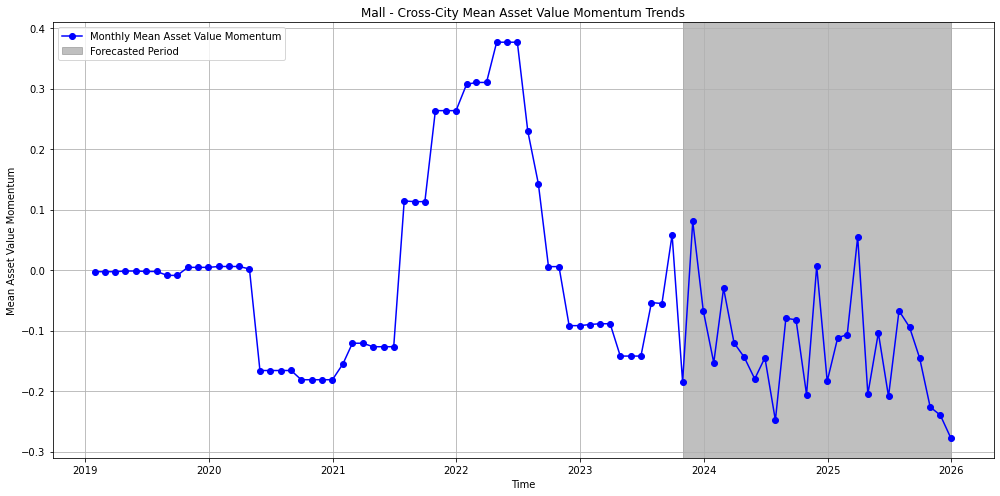

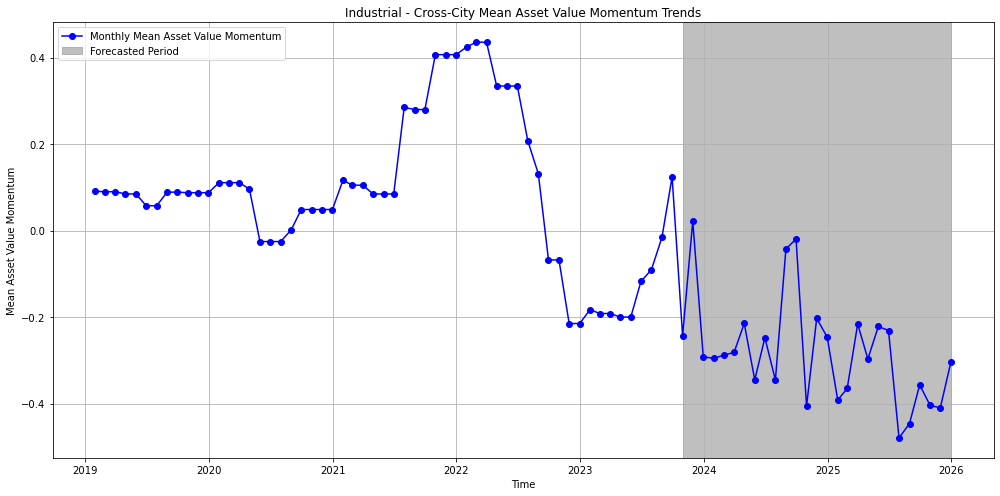

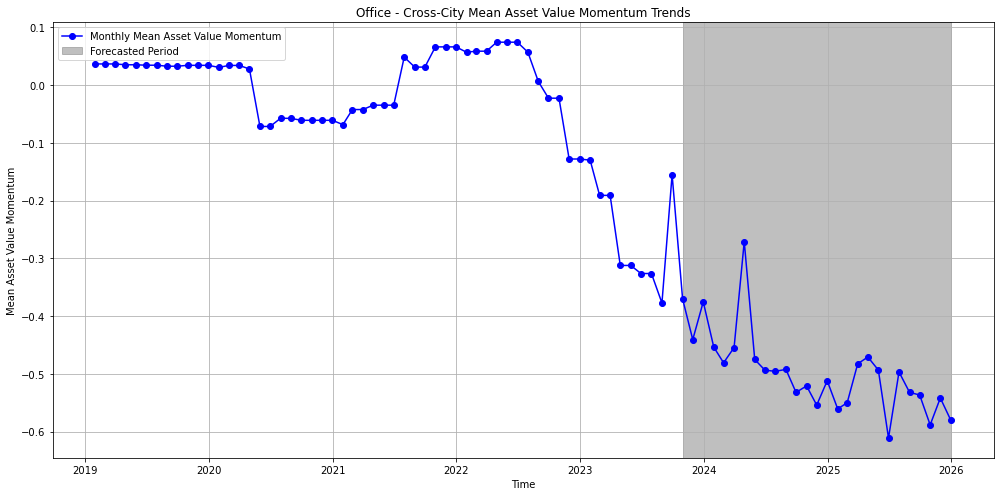

In [33]:
# ## Test de la classe HousingData
housing_data = HousingData('housing')

all_data = housing_data.load_cleansed_data()

# Aggregate data across cities for the 'Mall' property type
all_states = all_data.State.unique()
mall_aggregated_data = housing_data.aggregate_data_across_cities(states=all_states, property_type='Mall')

# Plotting the mean asset value momentum across cities
plot_monthly_mean_trend(
    mall_aggregated_data,
    x_col='period_begin',
    y_col='asset_value_momentum',
    title='Mall - Cross-City Mean Asset Value Momentum Trends',
    xlabel='Time',
    ylabel='Mean Asset Value Momentum',
    forecast_start=pd.to_datetime('2023-10-31'),
    forecast_end=pd.to_datetime('2025-12-31')
)


# Aggregate data across cities for the 'Mall' property type
all_states = all_data.State.unique()
industrial_aggregated_data = housing_data.aggregate_data_across_cities(states=all_states, property_type='Industrial')

# Plotting the mean asset value momentum across cities
plot_monthly_mean_trend(
    industrial_aggregated_data,
    x_col='period_begin',
    y_col='asset_value_momentum',
    title='Industrial - Cross-City Mean Asset Value Momentum Trends',
    xlabel='Time',
    ylabel='Mean Asset Value Momentum',
    forecast_start=pd.to_datetime('2023-10-31'),
    forecast_end=pd.to_datetime('2025-12-31')
)

# Aggregate data across cities for the 'Mall' property type
all_states = all_data.State.unique()
office_aggregated_data = housing_data.aggregate_data_across_cities(states=all_states, property_type='Office')

# Plotting the mean asset value momentum across cities
plot_monthly_mean_trend(
    office_aggregated_data,
    x_col='period_begin',
    y_col='asset_value_momentum',
    title='Office - Cross-City Mean Asset Value Momentum Trends',
    xlabel='Time',
    ylabel='Mean Asset Value Momentum',
    forecast_start=pd.to_datetime('2023-10-31'),
    forecast_end=pd.to_datetime('2025-12-31')
)

### Meilleurs classes d'actifs a acheter et/ou vendre

#### Objectif :
Faire une analyse des meilleurs types de biens immobiliers à acheter et à vendre en 2024 et 2025, en mettant l'accent sur les propriétés commerciales et résidentielles séparément. Cette distinction est cruciale en raison des différentes manières dont l'élan de la valeur des biens est calculé pour ces deux catégories.

#### Pourquoi cette separation est importante :
- **Dynamiques de Marché Différentes** : Les marchés immobiliers commerciaux et résidentiels ont des caractéristiques distinctes et sont influencés par différents facteurs. Leur élan de la valeur des biens peut être impacté par des tendances uniques, ce qui rend nécessaire une analyse séparée.
- **Comparaisons Précises** : En séparant ces deux catégories, nous pouvons effectuer des comparaisons plus précises et pertinentes au sein de chaque groupe, garantissant que notre analyse et nos recommandations reposent sur des comparaisons équivalentes.

#### Methodologie :

1. **Agrégation des Données** :
   - Nous utiliserons la méthode `aggregate_data_by_property` pour collecter des données agrégées par type de propriété pour toutes les villes et États disponibles. L'accent sera mis sur la colonne `asset_value_momentum`.

2. **Filtrage pour la Période Prévue** :
   - Créer une fonction pour filtrer les données agrégées afin d'inclure uniquement la période prévue (d'octobre 2023 à décembre 2025).

3. **Isolation des Années 2024 et 2025** :
   - À partir des données filtrées, nous isolerons les points de données correspondant aux années 2024 et 2025 en utilisant la colonne `period_begin`.

4. **Calcul de la Moyenne Annuelle** :
   - Calculer la moyenne annuelle de l'élan de la valeur des biens pour chaque type de propriété pour les années 2024 et 2025. Cela fournira un indicateur moyen de l'élan pour chaque type de propriété par an.

5. **Identification des Meilleurs Types de Propriétés** :
   - Comparer les valeurs moyennes de l'élan de la valeur des biens entre les types de propriétés pour chaque année. Nous le ferons séparément pour les propriétés commerciales (Bureau, Centre Commercial, Industriel) et résidentielles.
   - Le type de propriété ayant la moyenne d'élan la plus élevée dans une catégorie est considéré comme un bon candidat pour l'achat, car cela indique une appréciation potentielle de la valeur.

6. **Comparaison Annuelle** :
   - Pour trouver les meilleurs types de propriétés à vendre, nous comparerons les valeurs moyennes de l'élan entre 2024 et 2025 dans chaque catégorie.
   - Un type de propriété avec un élan élevé en 2024 suivi d'une baisse significative en 2025 pourrait indiquer une opportunité de vente en 2024 avant la chute. Inversement, une augmentation significative de 2024 à 2025 pourrait indiquer une opportunité de conservation ou d'achat.

7. **Amplitude du Changement** :
   - Analyser comment les meilleurs types de propriétés se comparent les uns aux autres en termes de chiffres en calculant l'amplitude du changement de l'élan de la valeur des biens de 2024 à 2025. Cela se fera en trouvant le pourcentage de changement entre les deux années pour chaque type de propriété dans chaque catégorie.

8. **Présentation des Résultats** :
   - Présenter les résultats en listant les types de propriétés par ordre de performance en fonction des amplitudes de l'augmentation ou de la diminution calculées. Cela fournira une indication claire des types de propriétés susceptibles de rapporter le plus si elles sont achetées ou vendues au bon moment.

#### Résumé :
En séparant notre analyse en catégories de propriétés commerciales et résidentielles, nous visons à fournir des informations plus ciblées et précises sur les opportunités d'investissement pour chacune d'entre elles. Cette approche aidera les investisseurs à prendre des décisions éclairées en se concentrant sur les dynamiques spécifiques de chaque segment de marché.

Pour trouver le type de propriété le plus propice à l'achat et à la vente en fonction de l'élan de la valeur de l'actif en 2024 et 2025, nous suivrons les étapes suivantes  :

1. **Agrégation des données** : Nous utiliserons d'abord la méthode `aggregate_data_by_property` pour obtenir les données agrégées par type de propriété à travers toutes les villes et les états disponibles dans le jeu de données. Cette agrégation sera réalisée sur la colonne `asset_value_momentum`.

2. **Filtrage des données pour la période de prévision** : Nous créerons une fonction pour filtrer les données agrégées afin d'inclure uniquement la période de prévision, c'est-à-dire d'octobre 2023 à décembre 2025.

3. **Isoler les années 2024 et 2025** : À partir des données filtrées, nous isolerons davantage les points de données correspondant aux années 2024 et 2025 en utilisant la colonne `period_begin`.

4. **Calcul de la moyenne annuelle** : Pour chaque type de propriété, nous calculerons la moyenne de `l'élan de la valeur de l'actif` pour les années 2024 et 2025. Cela nous donnera un indicateur moyen de l'élan pour chaque type de propriété par an.

5. **Identifier les meilleurs types de propriété** : En comparant les valeurs moyennes de l'élan entre les types de propriété pour chaque année, nous identifierons les types de propriété ayant la moyenne de l'élan la plus élevée en 2024 et 2025. Le type de propriété ayant la moyenne de l'élan la plus élevée est un bon candidat pour l'achat car il indique une possible appréciation de valeur.

6. **Comparaison entre les années** : Pour trouver les meilleurs types de propriété à vendre, nous comparerons les valeurs moyennes de l'élan entre 2024 et 2025. Un type de propriété avec un élan élevé en 2024 suivi d'une baisse significative en 2025 pourrait indiquer qu'il faut vendre en 2024 avant la baisse. À l'inverse, un type de propriété avec une augmentation significative de 2024 à 2025 pourrait être un indicateur de conservation ou d'achat.

7. **Magnitude du changement** : Pour analyser comment les meilleurs types de propriété se comparent les uns aux autres en termes de chiffres, nous calculerons la magnitude du changement de l'élan de la valeur de l'actif de 2024 à 2025. Cela se fera en trouvant le pourcentage de changement entre les deux années pour chaque type de propriété.

8. **Présentation des résultats** : Enfin, nous présenterons les résultats en listant les types de propriété par ordre de performance en fonction des magnitudes de l'augmentation ou de la diminution calculées. Cela fournira une indication claire des types de propriété susceptibles de rapporter le plus si vous les achetez ou les vendez au bon moment.

L'implémentation du code impliquera de parcourir les ensembles de données, d'appliquer des filtres, des agrégations et des comparaisons à l'aide des opérations de Pandas sur les DataFrame. Le processus sera itératif et exploratoire pour garantir l'identification des meilleurs types de propriété en fonction des données disponibles.nnées disponibles.

In [34]:
import pandas as pd
from datetime import datetime

# Functions for analysis
def filter_forecast_period(df, start_date, end_date):
    return df[(df['period_begin'] >= start_date) & (df['period_begin'] <= end_date)]

def calculate_yearly_mean(df):
    df['Year'] = df['period_begin'].dt.year
    return df.groupby(['Property_Type', 'Year'])['asset_value_momentum'].mean().reset_index()

def find_property_types_momentum(df):
    momentum_2024 = df[df['Year'] == 2024]
    momentum_2025 = df[df['Year'] == 2025]
    buy_momentum_2024 = momentum_2024.sort_values('asset_value_momentum', ascending=False)
    sell_momentum_change = momentum_2024[['Property_Type', 'asset_value_momentum']].merge(
        momentum_2025[['Property_Type', 'asset_value_momentum']], on='Property_Type', suffixes=('_2024', '_2025')
    )
    sell_momentum_change['Momentum_Change'] = sell_momentum_change['asset_value_momentum_2025'] - sell_momentum_change['asset_value_momentum_2024']
    sell_momentum_sorted = sell_momentum_change.sort_values('Momentum_Change', ascending=False)
    return buy_momentum_2024, sell_momentum_sorted

# Instantiate HousingData and load data
housing_data = HousingData('housing')
all_data = housing_data.load_cleansed_data()

# Filter data for the forecast period
forecast_data = filter_forecast_period(all_data, datetime(2023, 10, 1), datetime(2025, 12, 31))

# Define property type categories
commercial_property_types = ['Office', 'Mall', 'Industrial']
residential_property_types = ['Multi-Family (2-4 Units)', 'Condo', 'Townhouse', 'Single Family Residential', 'Multi-Family (2-4 Unit)']

# Filter for commercial and residential data
commercial_data = forecast_data[forecast_data['Property_Type'].isin(commercial_property_types)]
residential_data = forecast_data[forecast_data['Property_Type'].isin(residential_property_types)]

# Perform analysis
yearly_momentum_commercial = calculate_yearly_mean(commercial_data)
yearly_momentum_residential = calculate_yearly_mean(residential_data)
buy_momentum_commercial, sell_momentum_commercial = find_property_types_momentum(yearly_momentum_commercial)
buy_momentum_residential, sell_momentum_residential = find_property_types_momentum(yearly_momentum_residential)

# Function to display tables
def display_formatted_table(df, title):
    print(title)
    print(df.to_markdown(index=False))  # Markdown format for table

# Displaying the results
display_formatted_table(buy_momentum_commercial, "Buying Recommendations for Commercial Properties in 2024")
display_formatted_table(sell_momentum_commercial, "Selling Recommendations for Commercial Properties Between 2024 and 2025")
display_formatted_table(buy_momentum_residential, "Buying Recommendations for Residential Properties in 2024")
display_formatted_table(sell_momentum_residential, "Selling Recommendations for Residential Properties Between 2024 and 2025")

Buying Recommendations for Commercial Properties in 2024
| Property_Type   |   Year |   asset_value_momentum |
|:----------------|-------:|-----------------------:|
| Mall            |   2024 |              -0.130499 |
| Industrial      |   2024 |              -0.244674 |
| Office          |   2024 |              -0.478014 |
Selling Recommendations for Commercial Properties Between 2024 and 2025
| Property_Type   |   asset_value_momentum_2024 |   asset_value_momentum_2025 |   Momentum_Change |
|:----------------|----------------------------:|----------------------------:|------------------:|
| Mall            |                   -0.130499 |                   -0.143475 |        -0.0129752 |
| Office          |                   -0.478014 |                   -0.535346 |        -0.0573325 |
| Industrial      |                   -0.244674 |                   -0.34287  |        -0.0981958 |
Buying Recommendations for Residential Properties in 2024
| Property_Type             |   Year |   as

/tmp/ipykernel_3889890/2419737475.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['period_begin'].dt.year


### Propriétés Commerciales (2024 et 2024-2025)

#### Recommandations d'Achat pour 2024 :
- Tous les types de propriétés commerciales (Centre Commercial, Industriel, Bureau) présentent un élan négatif de la valeur de l'actif en 2024.
- L'élan le moins négatif est observé dans les **Centres Commerciaux**, ce qui indique que parmi les propriétés commerciales, les centres commerciaux pourraient être l'option d'investissement la moins risquée pour 2024.

#### Recommandations de Vente (2024-2025) :
- Une nouvelle diminution de l'élan de la valeur de l'actif de 2024 à 2025 est notée pour tous les types de propriétés commerciales.
- Les **Centres Commerciaux** affichent la plus petite diminution de l'élan, suggérant que leur valeur pourrait ne pas diminuer aussi rapidement que d'autres types.
- Les propriétés de **Bureaux** et **Industrielles** connaissent des baisses plus importantes, indiquant une éventuelle dépréciation de la valeur, et pourraient ne pas être idéales à détenir au-delà de 2024.

### Propriétés Résidentielles (2024 et 2024-2025)

#### Recommandations d'Achat pour 2024 :
- Tous les types de propriétés résidentielles présentent un élan positif en 2024, indiquant un potentiel d'appréciation de la valeur.
- Les propriétés **Multi-Family (2-4 Unités)** montrent un élan positif, bien que nettement inférieur à celui des propriétés "Toutes Résidentielles" et "Résidentielles Individuelles".
- Les **Appartements** et les **Maisons de Ville** ont un élan positif mais il est considérablement plus faible que celui d'autres types de résidences.

#### Recommandations de Vente (2024-2025) :
- Une diminution de l'élan est observée pour tous les types de propriétés résidentielles de 2024 à 2025.
- Les propriétés **Multi-Family (2-4 Unités)** montrent une diminution relativement plus faible de l'élan, suggérant une valeur plus stable.
- Les **Appartements** et les **Maisons de Ville** affichent une diminution de l'élan, indiquant des défis potentiels pour la conservation de la valeur.
- Les propriétés "Résidentielles Individuelles" connaissent des baisses significatives de l'élan, suggérant une éventuelle dépréciation de la valeur, ce qui les rend moins idéales à détenir au-delà de 2024.

### Recommandations :

#### Pour les Propriétés Commerciales :
- **Investir Prudemment** : Compte tenu de l'élan négatif global des propriétés commerciales, les investissements dans ce secteur devraient être abordés avec prudence.
- **Investissement Potentiel dans les Centres Commerciaux** : Envisagez d'investir dans les centres commerciaux pour les propriétés commerciales en raison de leur élan relativement stable.

#### Pour les Propriétés Résidentielles :
- **Investissez dans les "Toutes Résidentielles" ou les "Résidentielles Individuelles" en 2024** : Ces propriétés présentent un élan positif en 2024 et sont de bonnes options pour un investissement à court terme.
- **Surveillez les Propriétés "Multi-Family (2-4 Unités)"** : Bien que leur élan soit plus faible, elles sont relativement stables et pourraient convenir à une stratégie d'investissement conservatrice.
- **Envisagez de Vendre en 2025** : Compte tenu de la diminution attendue de l'élan dans tous les types de propriétés résidentielles, prévoyez des ventes potentielles avant 2025 pour éviter la dépréciation de la valeur.

### Précautions :
- **Variabilité du Marché** : Les marchés immobiliers peuvent être très variables et influencés par des facteurs externes tels que les conditions économiques, les taux d'intérêt et la dynamique du marché local.
- **Diversification** : Diversifiez votre portefeuille immobilier en investissant dans différents types de propriétés et dans différentes régions pour atténuer les risques.
- **Analyse Régulière du Marché** : Restez informé des tendances du marché et adaptez vos stratégies d'investissement en conséquence.

Cette analyse offre une approche stratégique de l'investissement immobilier, axée sur l'identification des opportunités en fonction de l'élan anticipé de la valeur de l'actif, tout en tenant compte des risques potentiels.

### Meilleures villes

### Objectif :
Identifier les meilleures et les pires villes pour les investissements immobiliers commerciaux et résidentiels séparément, puis déterminer les types de propriétés les plus et les moins favorables au sein des 10 meilleures villes pour les deux catégories.

### Comment allons-nous procéder ?

#### 1. Identification des Meilleures et des Pires Villes :
- **Agrégation des Données par Ville** : Regrouper les données sur l'élan de la valeur de l'actif pour les propriétés commerciales et résidentielles séparément pour chaque ville.
- **Calcul de la Moyenne de l'Élan pour 2024 et 2025** : Pour chaque ville, calculer la moyenne de l'élan de la valeur de l'actif pour les propriétés commerciales et résidentielles pour les années 2024 et 2025.
- **Classement des Villes** : Classer les villes en fonction de la moyenne de l'élan pour les deux catégories. Les villes avec la moyenne d'élan la plus élevée dans chaque catégorie seront identifiées comme les meilleures pour l'investissement, tandis que celles avec la moyenne la plus basse seront marquées comme moins favorables.

#### 2. Analyse des Types de Propriétés dans les 10 Meilleures Villes :
- **Sélection des 10 Meilleures Villes** : En fonction du classement, sélectionner les 10 meilleures villes avec le plus haut élan de la valeur de l'actif pour les propriétés commerciales et résidentielles.
- **Analyse des Types de Propriétés dans Chaque Ville** : Pour chacune de ces villes, analyser l'élan de la valeur de l'actif pour les différents types de propriétés commerciales et résidentielles.
- **Identification des Meilleurs et des Pires Types de Propriétés** : À l'intérieur de chaque ville, identifier les types de propriétés qui affichent le plus haut et le plus bas élan pour les années 2024 et 2025.

### Justification de cette Approche :
- **Stratégie d'Investissement Ciblée** : Cette approche permettra aux investisseurs d'adapter leurs stratégies en fonction des forces et des faiblesses spécifiques des marchés immobiliers commerciaux et résidentiels dans différentes villes.
- **Perspectives Larges et Approfondies** : Le processus en deux étapes offre à la fois une vue d'ensemble (au niveau de la ville) et des informations détaillées (au niveau des types de propriétés), ce qui permet une prise de décision stratégique.
- **Adaptation aux Tendances Actuelles** : En se concentrant séparément sur les propriétés commerciales et résidentielles, les investisseurs peuvent mieux s'adapter aux tendances actuelles et émergentes qui affectent chaque secteur.

La mise en œuvre impliquera une analyse des données à l'aide d'opérations Pandas en Python, en se concentrant sur le filtrage, l'agrégation et l'analyse comparative pour tirer des conclusions significatives pour la planification des investissements en 2024 et 2025.

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Assuming HousingData class is defined as before
housing_data = HousingData('housing')

# Function to filter data for commercial and residential properties
def filter_data_by_type(df, property_types):
    return df[df['Property_Type'].isin(property_types)]

# Function to calculate average asset value momentum for each city in a given year
def average_momentum_by_city(df, year):
    yearly_data = df[df['period_begin'].dt.year == year]
    return yearly_data.groupby('City')['asset_value_momentum'].mean().reset_index()

# Function to identify top and bottom cities for investment based on asset value momentum
def top_and_bottom_cities_for_investment(df, years, top_n=10):
    momentum_data = {}
    for year in years:
        momentum_data[year] = average_momentum_by_city(df, year)
    combined = pd.merge(momentum_data[years[0]], momentum_data[years[1]], on='City', suffixes=years)
    combined['Average_Momentum'] = combined.mean(axis=1)
    top_cities = combined.sort_values('Average_Momentum', ascending=False).head(top_n)
    bottom_cities = combined.sort_values('Average_Momentum').head(top_n)
    return top_cities, bottom_cities

# Function to analyze property types in given cities for a specific year
def analyze_property_types_in_cities(df, cities, year):
    results = {}
    for city in cities:
        city_data = df[(df['City'] == city) & (df['period_begin'].dt.year == year)]
        property_type_momentum = city_data.groupby('Property_Type')['asset_value_momentum'].mean().sort_values(ascending=False)
        results[city] = property_type_momentum
    return results

# Function to scale dataframe for plotting
def scale_dataframe(df, column):
    scaler = MinMaxScaler()
    df[column] = scaler.fit_transform(df[[column]])
    return df

# Function to plot combined city momentum
def plot_combined_city_momentum(top_df, bottom_df, title):
    top_df = scale_dataframe(top_df, 'Average_Momentum')
    bottom_df = scale_dataframe(bottom_df, 'Average_Momentum')
    combined_df = pd.concat([top_df, bottom_df], keys=['Top', 'Bottom']).reset_index(level=0).rename(columns={'level_0': 'Category'})
    plt.figure(figsize=(14, 7))
    sns.barplot(x='City', y='Average_Momentum', hue='Category', data=combined_df)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.ylabel('Scaled Asset Value Momentum')
    plt.xlabel('City')
    plt.tight_layout()
    plt.show()

# Function to prepare data for heatmap
def prepare_heatmap_data(city_data_dict):
    heatmap_df = pd.DataFrame()
    for city, data in city_data_dict.items():
        city_df = data.to_frame(city).T
        heatmap_df = pd.concat([heatmap_df, city_df], sort=False)
    heatmap_df.fillna(0, inplace=True)
    scaler = MinMaxScaler()
    heatmap_df = pd.DataFrame(scaler.fit_transform(heatmap_df), columns=heatmap_df.columns, index=heatmap_df.index)
    return heatmap_df

# Load data
all_data = housing_data.load_cleansed_data()

# Filter data for commercial and residential properties
commercial_property_types = ['Mall', 'Office', 'Industrial']
residential_property_types = ['Single Family Residential', 'Condo', 'Townhouse', 'Multi-Family (2-4 Unit)']

commercial_data = filter_data_by_type(all_data, commercial_property_types)
residential_data = filter_data_by_type(all_data, residential_property_types)

# Analyze top and bottom cities for commercial and residential properties
top_commercial_cities, bottom_commercial_cities = top_and_bottom_cities_for_investment(commercial_data, [2024, 2025], top_n=10)
top_residential_cities, bottom_residential_cities = top_and_bottom_cities_for_investment(residential_data, [2024, 2025], top_n=10)

# Analyze property types in top cities for 2024
property_type_analysis_commercial_top_2024 = analyze_property_types_in_cities(commercial_data, top_commercial_cities['City'], 2024)
property_type_analysis_residential_top_2024 = analyze_property_types_in_cities(residential_data, top_residential_cities['City'], 2024)

# Prepare data for heatmap
heatmap_data_commercial = prepare_heatmap_data(property_type_analysis_commercial_top_2024)
heatmap_data_residential = prepare_heatmap_data(property_type_analysis_residential_top_2024)

# Print the tables in a nicely formatted way
print("Top 10 Commercial Cities for Investment Based on Asset Value Momentum:")
print(top_commercial_cities.to_string(index=False, formatters={'Average_Momentum':'{:.2f}'.format}))

print("\nBottom 10 Commercial Cities for Investment Based on Asset Value Momentum:")
print(bottom_commercial_cities.to_string(index=False, formatters={'Average_Momentum':'{:.2f}'.format}))

print("\nTop 10 Residential Cities for Investment Based on Asset Value Momentum:")
print(top_residential_cities.to_string(index=False, formatters={'Average_Momentum':'{:.2f}'.format}))

print("\nBottom 10 Residential Cities for Investment Based on Asset Value Momentum:")
print(bottom_residential_cities.to_string(index=False, formatters={'Average_Momentum':'{:.2f}'.format}))

Top 10 Commercial Cities for Investment Based on Asset Value Momentum:
       City  asset_value_momentum2024  asset_value_momentum2025 Average_Momentum
Jersey City                 -0.013120                 -0.063367            -0.04
     Dallas                 -0.228442                 -0.234278            -0.23
Los Angeles                 -0.229477                 -0.248189            -0.24
  San Diego                 -0.246062                 -0.271592            -0.26
 Sacramento                 -0.254750                 -0.284851            -0.27
     Boston                 -0.280653                 -0.261071            -0.27
 Washington                 -0.257363                 -0.286188            -0.27
      Miami                 -0.247524                 -0.300154            -0.27
 Louisville                 -0.242385                 -0.309781            -0.28
    Houston                 -0.258377                 -0.325073            -0.29

Bottom 10 Commercial Cities for Inves

/tmp/ipykernel_3889890/13741252.py:24: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  combined['Average_Momentum'] = combined.mean(axis=1)


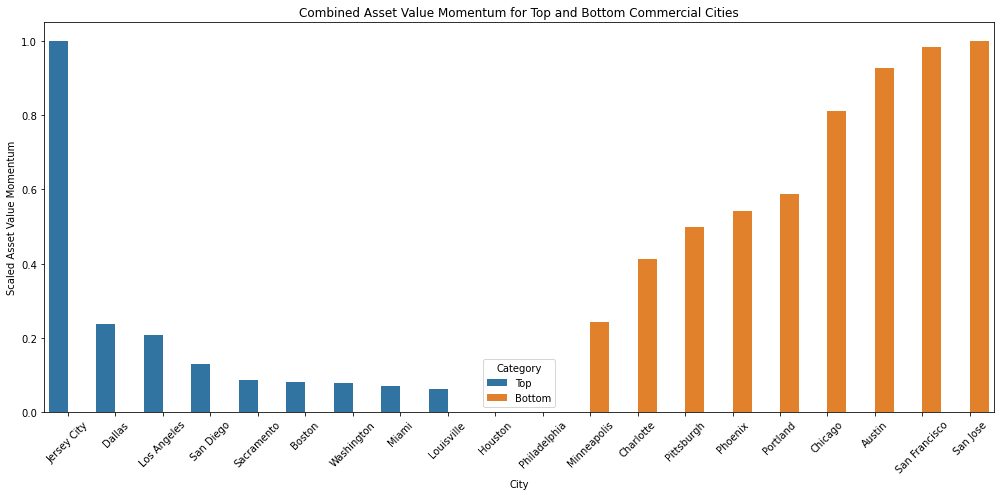

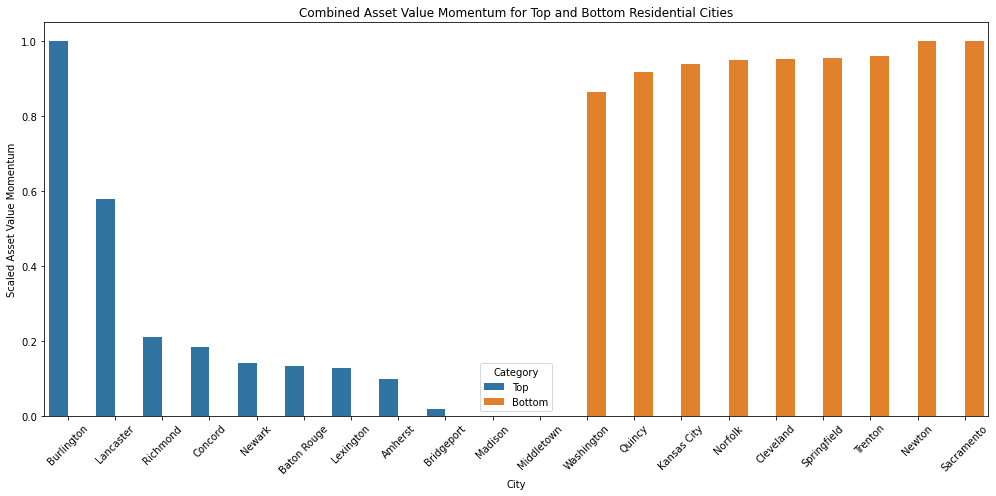

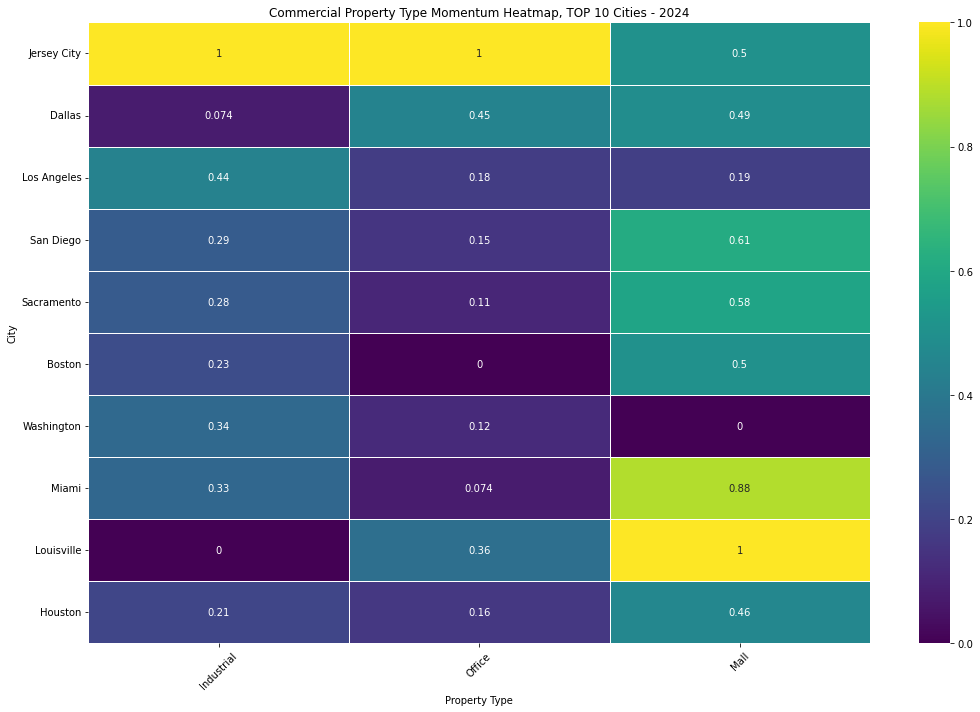

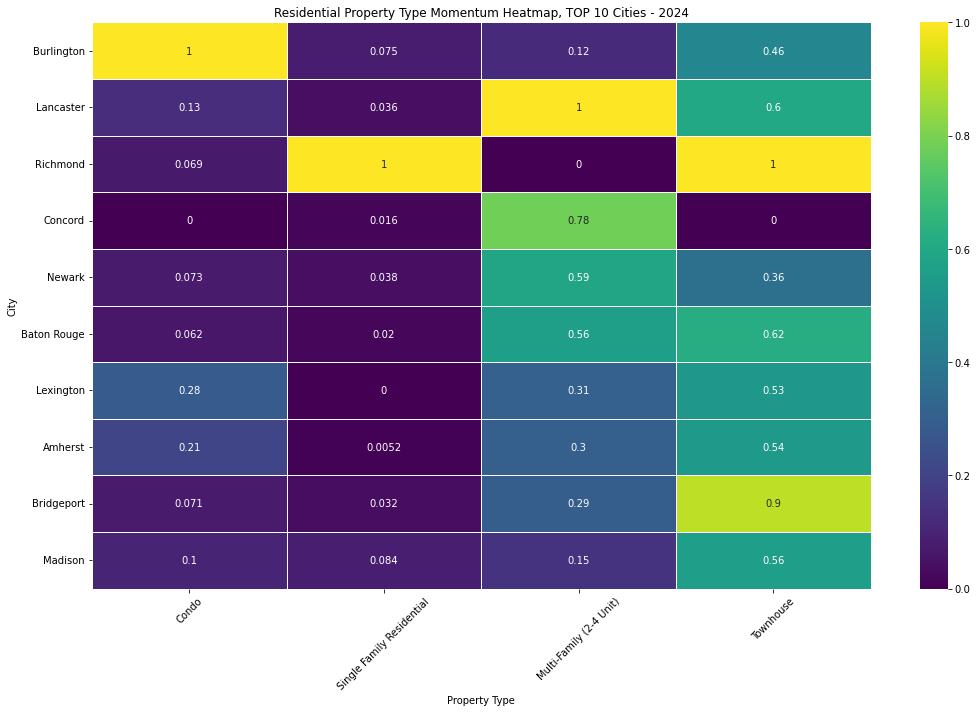

In [36]:
# Plotting
plot_combined_city_momentum(top_commercial_cities, bottom_commercial_cities, "Combined Asset Value Momentum for Top and Bottom Commercial Cities")
plot_combined_city_momentum(top_residential_cities, bottom_residential_cities, "Combined Asset Value Momentum for Top and Bottom Residential Cities")

plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data_commercial, annot=True, cmap='viridis', linewidths=.5)
plt.title("Commercial Property Type Momentum Heatmap, TOP 10 Cities - 2024")
plt.ylabel('City')
plt.xlabel('Property Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data_residential, annot=True, cmap='viridis', linewidths=.5)
plt.title("Residential Property Type Momentum Heatmap, TOP 10 Cities - 2024")
plt.ylabel('City')
plt.xlabel('Property Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Analyse et Recommandations

#### Propriétés Commerciales (2024 et 2024-2025)

**Recommandations d'Achat pour 2024 :**
- Les **Centres Commerciaux** présentent la moins forte décroissance de la dynamique de la valeur d'actif parmi les propriétés commerciales, suggérant qu'ils pourraient être l'option d'investissement la moins risquée dans le secteur commercial pour 2024.

**Recommandations de Vente (2024-2025) :**
- Les **Centres Commerciaux** montrent la plus faible baisse de dynamique de 2024 à 2025, suggérant que leur valeur pourrait ne pas diminuer aussi rapidement que d'autres types de propriétés.
- Les propriétés **de Bureau** et **Industrielles** connaissent des baisses plus significatives, ce qui indique une possible dépréciation de la valeur, les rendant moins idéales à détenir au-delà de 2024.

#### Propriétés Résidentielles (2024 et 2024-2025)

**Recommandations d'Achat pour 2024 :**
- Toutes les propriétés **Résidentielles** affichent une dynamique positive, indiquant un potentiel d'appréciation de la valeur. Cette catégorie inclut les propriétés **Multi-Familiales (2-4 Unités)**, qui montrent maintenant également une tendance positive.
- Les **Appartements** et les **Maisons de Ville** présentent une dynamique positive, mais significativement moins forte que d'autres types de résidences.

**Recommandations de Vente (2024-2025) :**
- Une baisse de la dynamique est observée pour tous les types de propriétés résidentielles de 2024 à 2025.
- Les propriétés **Multi-Familiales (2-4 Unités)** sont les seules à montrer une augmentation de la dynamique de 2024 à 2025, suggérant une stabilité ou un potentiel de croissance de la valeur.
- Les **Appartements** et les **Maisons de Ville** montrent une baisse de dynamique relativement plus faible, ce qui suggère une valeur plus stable.

### Recommandations Générales

**Pour les Propriétés Commerciales :**
- Faites preuve de prudence dans vos investissements, compte tenu de la dynamique globalement négative des propriétés commerciales.
- Considérez les centres commerciaux comme une option d'investissement potentielle en raison de leur dynamique relativement stable.

**Pour les Propriétés Résidentielles :**
- Investissez dans les propriétés **Résidentielles Individuelles** en 2024 car elles affichent une dynamique positive.
- Gardez un œil sur les propriétés **Multi-Familiales (2-4 Unités)**, qui peuvent représenter une opportunité d'investissement stable en raison de leur dynamique croissante.
- Envisagez de vendre avant 2025, compte tenu de la baisse attendue de la dynamique pour la plupart des types de propriétés résidentielles.

### Résumé et Recommandations

**Propriétés Commerciales dans les Grandes Villes (2024) :**
- **Jersey City** semble avoir une dynamique de valeur d'actif relativement meilleure, en faisant un choix plus sûr pour les investissements commerciaux.
- **Dallas** montre de la résilience dans le secteur commercial, avec les propriétés industrielles comme point fort notable.
- **Los Angeles** indique également un potentiel dans le secteur industriel avec une dynamique positive.

**Propriétés Résidentiel les dans les Grandes Villes (2024) :**
- **Burlington** et **Richmond** suivent avec des tendances et des opportunités d'investissement prometteuses.
- **Newark** et **Baton Rouge** présentent une dynamique modérée mais positive, indiquant un potentiel de croissance stable.

**Considérations d'Investissement :**
- **Commercial** : Compte tenu du mouvement global négatif, les investisseurs devraient envisager Jersey City, Dallas et Los Angeles, en se concentrant sur le marché des propriétés industrielles.
- **Résidentiel** : Burlington se démarque comme un candidat idéal pour l'investissement résidentiel, avec Richmond, Newark et Baton Rouge offrant des opportunités de croissance stables.

**Perspectives Stratégiques :**
- La diversification au sein des types de propriétés commerciales peut atténuer les tendances globalement négatives.
- Les investissements résidentiels montrent une croissance, mais il est essentiel de surveiller les tendances et de vendre avant les éventuelles baisses en 2025, en particulier pour les maisons unifamiliales.
- Les propriétés **Multi-Familiales (2-4 Unités)** présentent un potentiel unique de croissance et de stabilité, ce qui en fait une option intéressante pour les investisseurs axés sur les marchés résidentiels.

**Informations Visuelles des Données :**
- Les données visuelles des cartes thermiques et des graphiques à barres devraient guider les investisseurs vers les villes spécifiques et les types de propriétés démontrant une dynamique favorable ou une résistance aux tendances négatives.

### Conclusion

Le paysage de l'investissement immobilier présente des défis et des opportunités variables dans les secteurs commercial et résidentiel. Les investisseurs devraient se concentrer stratégiquement sur les marchés à croissance positive de la valeur d'actif ou à la dynamique la moins négative pour les propriétés commerciales, et sur les indicateurs de croissance solides comme Burlington pour les investissements résidentiels. Il est conseillé de prendre en compte les facteurs économiques externes, les taux d'intérêt et les tendances générales du marché qui peuvent influencer la valeur des propriétés au-delà de la dynamique observée. Des révisions régulières du marché et des ajustements de stratégie basés sur les données les plus récentes sont recommandés pour une navigation efficace sur le marché immobilier en constante évolution.

Top Cities by Property Type for Asset Value Momentum in 2023:


,Property_Type,City,asset_value_momentum,Year,scaled_asset_value_momentum
0,Condo,Lawrence,0.657056,2023,0.308536
1,Condo,Burlington,0.452727,2023,0.247164
2,Condo,Savannah,0.298584,2023,0.200866
3,Industrial,Los Angeles,-0.044441,2023,0.097836
4,Industrial,New York,-0.052186,2023,0.095509
5,Industrial,Orange,-0.053174,2023,0.095213
6,Mall,Miami,-0.028966,2023,0.102484
7,Mall,Houston,-0.037089,2023,0.100044
8,Mall,Dallas,-0.039583,2023,0.099295
9,Multi-Family (2-4 Unit),Lancaster,0.791337,2023,0.348869


Top Cities by Property Type for Asset Value Momentum in 2024:


,Property_Type,City,asset_value_momentum,Year,scaled_asset_value_momentum
0,Condo,Burlington,1.841473,2024,0.664286
1,Condo,Lexington,0.464830,2024,0.250800
2,Condo,Savannah,0.460362,2024,0.249458
3,Industrial,Jersey City,0.096096,2024,0.140047
4,Industrial,Baltimore,-0.123819,2024,0.073994
5,Industrial,Los Angeles,-0.127302,2024,0.072948
6,Mall,Salt Lake City,-0.052589,2024,0.095389
7,Mall,Jacksonville,-0.057324,2024,0.093966
8,Mall,Louisville,-0.068657,2024,0.090562
9,Multi-Family (2-4 Unit),Lancaster,1.436426,2024,0.542626


Top Cities by Property Type for Asset Value Momentum in 2025:


,Property_Type,City,asset_value_momentum,Year,scaled_asset_value_momentum
0,Condo,Burlington,2.959186,2025,1.000000
1,Condo,Lawrence,0.908547,2025,0.384074
2,Condo,Savannah,0.433247,2025,0.241313
3,Industrial,Jersey City,0.023618,2025,0.118278
4,Industrial,San Francisco,-0.142308,2025,0.068441
5,Industrial,Sacramento,-0.157978,2025,0.063734
6,Mall,Austin,-0.049246,2025,0.096393
7,Mall,Kansas City,-0.074673,2025,0.088755
8,Mall,Orlando,-0.081016,2025,0.086850
9,Multi-Family (2-4 Unit),Lancaster,1.461469,2025,0.550148


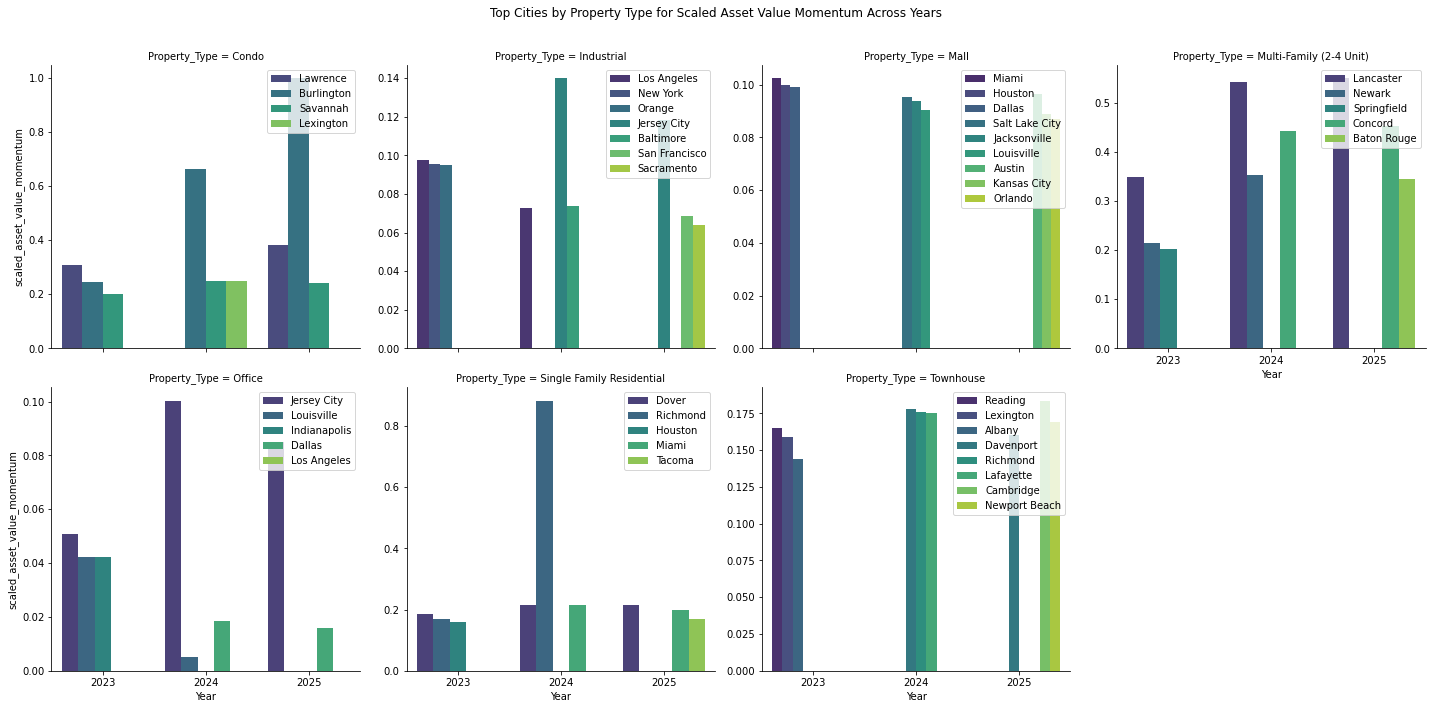

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display

# Assuming the HousingData class is already defined
housing_data = HousingData('housing')

def filter_data(df):
    """Filter out data for 'Auburn' city and 'All_Residential' property types."""
    return df[(df['City'] != 'Auburn') & (df['Property_Type'] != 'All_Residential')]

def aggregate_data_by_property_type(df, year):
    """Aggregate data by property type across all cities for a given year."""
    yearly_data = df[df['period_begin'].dt.year == year]
    return yearly_data.groupby(['Property_Type', 'City'])['asset_value_momentum'].mean().reset_index()

def top_cities_by_property_type(df, year):
    """Identify top 3 cities for each property type based on asset value momentum."""
    aggregated_data = aggregate_data_by_property_type(df, year)
    top_cities = aggregated_data.groupby('Property_Type').apply(lambda x: x.nlargest(3, 'asset_value_momentum')).reset_index(drop=True)
    return top_cities

def combine_yearly_data(all_data, years):
    """Combine the top cities data for each year into one DataFrame."""
    combined_data = pd.DataFrame()
    for year in years:
        yearly_data = top_cities_by_property_type(all_data, year)
        yearly_data['Year'] = year
        combined_data = pd.concat([combined_data, yearly_data], axis=0)
    return combined_data

def scale_data(combined_data):
    """Scale the asset value momentum for visualization."""
    scaler = MinMaxScaler()
    combined_data['scaled_asset_value_momentum'] = scaler.fit_transform(combined_data[['asset_value_momentum']])
    return combined_data

def plot_combined_data(combined_data):
    """Plot a multi-panel categorical plot for each property type with scaled data, each with its own legend."""
    # Plotting
    g = sns.FacetGrid(combined_data, col="Property_Type", col_wrap=4, height=5, sharey=False)
    
    def custom_barplot(x, y, hue, data, **kwargs):
        ax = plt.gca()  # Get the current Axes instance on the current figure
        sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax, **kwargs)

    g.map_dataframe(custom_barplot, x="Year", y="scaled_asset_value_momentum", hue="City", palette='viridis')

    # Adjust layout and add individual legends
    for ax in g.axes.ravel():
        ax.legend(loc='upper right')

    plt.subplots_adjust(top=0.9)
    g.fig.suptitle("Top Cities by Property Type for Scaled Asset Value Momentum Across Years")
    plt.show()

def display_yearly_tables(combined_data, years):
    """Display separate tables for each year."""
    for year in years:
        print(f"Top Cities by Property Type for Asset Value Momentum in {year}:")
        display(combined_data[combined_data['Year'] == year])

# Load data
all_data = housing_data.load_cleansed_data()

# Filter out 'Auburn' city and 'All_Residential' property types
filtered_data = filter_data(all_data)

# Years for analysis
years_to_analyze = [2023, 2024, 2025]

# Combine and analyze data for all years
combined_top_cities = combine_yearly_data(filtered_data, years_to_analyze)

# Scale the data
scaled_combined_top_cities = scale_data(combined_top_cities)

# Print the separate tables for each year
display_yearly_tables(scaled_combined_top_cities, years_to_analyze)

# Plotting the combined and scaled data with individual legends
plot_combined_data(scaled_combined_top_cities)


**Recommandations en matière d'investissement immobilier pour 2024 et 2025**

Les recommandations suivantes sont basées sur l'analyse des données et les informations visuelles pour les investissements immobiliers en 2024 et 2025. Cette section résume nos conclusions, mettant en évidence les informations clés concernant les propriétés commerciales et résidentielles, les recommandations spécifiques pour certaines villes, ainsi que les considérations générales pour les investisseurs immobiliers.

**Propriétés commerciales (2024 et 2025) :**

*Recommandations d'achat pour 2024 :*
- Considérez l'investissement dans les **propriétés industrielles** à Jersey City, car elles affichent un retournement de tendance positif en 2024.
- Malgré la tendance négative précédente, les centres commerciaux de Salt Lake City montrent une tendance relativement moins négative pour 2024 par rapport à d'autres villes, indiquant une stabilité relative.

*Recommandations de vente (2024-2025) :*
- Les propriétés de bureau continuent d'afficher une tendance négative dans l'ensemble, en particulier à Jersey City, à Dallas et à Los Angeles, suggérant une éventuelle dépréciation de la valeur.
- Les propriétés industrielles dans des villes telles que San Francisco et Sacramento sont prévues pour maintenir leur tendance négative jusqu'en 2025, indiquant des risques potentiels pour les investissements à long terme.

**Propriétés résidentielles (2024 et 2025) :**

*Recommandations d'achat pour 2024 :*
- Les propriétés résidentielles unifamiliales à Richmond présentent une augmentation significative de la dynamique de valeur de 2023 à 2024, indiquant un fort potentiel d'appréciation.
- Les propriétés multifamiliales (2-4 unités) à Lancaster et à Concord affichent une dynamique positive, suggérant un investissement stable avec un potentiel de croissance.
- Les maisons de ville à Davenport affichent également une dynamique positive, en faisant ainsi une opportunité d'investissement attrayante.

*Recommandations de vente (2024-2025) :*
- Les propriétés résidentielles unifamiliales et les appartements en copropriété, bien qu'ayant une dynamique positive prévue pour 2024, pourraient connaître un ralentissement en 2025. Dans les villes où la dynamique est en baisse, comme Miami pour les propriétés résidentielles unifamiliales et éventuellement Savannah pour les appartements en copropriété, les investisseurs pourraient envisager de vendre ces propriétés en 2024 pour maximiser les rendements avant que la croissance ne ralentisse.
- Les propriétés multifamiliales (2-4 unités) à Lancaster et à Concord ne sont pas seulement prévues pour afficher une dynamique positive en 2024, mais aussi une croissance continue jusqu'en 2025, suggérant qu'elles pourraient valoir la peine d'être détenues au-delà de 2024 pour des rendements stables ou en augmentation.

**Recommandations générales :**

*Pour les propriétés commerciales :*
- Les propriétés industrielles à Jersey City offrent une opportunité unique avec un changement positif de dynamique.
- Compte tenu de la dynamique générale négative des propriétés commerciales, une sélection prudente basée sur les tendances spécifiques à chaque ville est cruciale. Dallas et Los Angeles pourraient offrir des opportunités industrielles dignes d'intérêt en raison de leur dynamique moins négative.

*Pour les propriétés résidentielles :*
- L'investissement dans toutes les propriétés résidentielles en 2024 est recommandé, avec Richmond en tant que ville phare.
- Les propriétés multifamiliales (2-4 unités) à Lancaster et à Concord affichent une tendance à la hausse, suggérant des investissements stables à long terme en raison de leur dynamique croissante.
- Les maisons de ville dans des villes telles que Davenport et Lafayette présentent également une forte tendance positive, les rendant attrayantes à l'achat en 2024 dans l'optique de bénéficier de la poursuite de l'appréciation de la valeur.

*Recommandations de vente (2024-2025) :*
- Les propriétés résidentielles unifamiliales et les appartements en copropriété, bien que prévues pour afficher une dynamique positive en 2024, montrent des signes de ralentissement en 2025. Dans les villes où la dynamique diminue, comme Miami pour les propriétés résidentielles unifamiliales et potentiellement Savannah pour les appartements en copropriété, les investisseurs peuvent envisager de vendre ces propriétés en 2024 pour maximiser les rendements.
- Les propriétés multifamiliales (2-4 unités) à Lancaster et à Concord affichent non seulement une dynamique positive prévue jusqu'en 2024, mais aussi une croissance continue jusqu'en 2025, suggérant qu'elles pourraient valoir la peine d'être détenues au-delà de 2024 pour des rendements stables ou en augmentation.

**Recommandations spécifiques par ville :**

- Richmond se distingue pour toutes les propriétés résidentielles avec la dynamique de valeur à l'échelle la plus élevée pour 2024, indiquant une croissance solide et une solide opportunité d'investissement.
- Burlington pour les appartements en copropriété montre une augmentation remarquable de la dynamique de valeur de 2023 à 2024, et elle maintient la première position jusqu'en 2025, mettant en évidence un investissement potentiellement lucratif.
- Jersey City a montré une notable reprise pour les propriétés industrielles, ce qui pourrait intéresser les investisseurs à la recherche d'investissements immobiliers commerciaux avec des perspectives positives.
- Lancaster se distingue comme un leader constant pour les propriétés multifamiliales (2-4 unités), reflétant un marché solide et stable pour ce type de propriété.

Ce résumé des recommandations en matière d'investissement immobilier pour 2024 et 2025 offre des informations précieuses sur les opportunités et les risques liés à différents types de propriétés et à différentes villes. Les investisseurs sont encouragés à prendre en compte ces conclusions, à surveiller les tendances du marché et à adapter leurs stratégies en conséquence pour naviguer efficacement dans le marché immobilier en constante évolution.

### Analyse de la Performance des Grandes Villes des États-Unis pour l'Investissement Immobilier

Effectuer une analyse des 10 principales grandes villes des États-Unis en fonction de leur population, séparément des 10 villes précédemment identifiées comme les meilleures et les moins bonnes pour l'investissement en fonction de l'élan de la valeur de l'actif, est crucial pour plusieurs raisons :

1. **Signification Économique** : Les 10 principales grandes villes des États-Unis, telles que New York, Los Angeles et Chicago, sont des centres économiques significatifs. Les investissements dans ces villes sont souvent considérés comme plus sûrs en raison de leurs économies stables et robustes.

2. **Opportunités Diversifiées** : Ces villes offrent une large gamme d'opportunités d'investissement en raison de leur démographie diversifiée, de leurs industries variées et de leurs marchés immobiliers différents. Cette diversité permet une stratégie d'investissement plus complète.

3. **Analyse Comparative** : En analysant ces grandes villes aux côtés des villes précédemment identifiées comme les meilleures et les moins bonnes pour l'investissement, les investisseurs peuvent comparer les opportunités dans différents types de marché, des villes en croissance rapide aux centres urbains établis.

4. **Accent sur les Propriétés Commerciales** : Pour les propriétés commerciales dans ces villes (centres commerciaux, bureaux, industriels), prendre en compte des facteurs tels que la désirabilité et le taux d'occupation, en plus de l'élan de la valeur de l'actif, offre une vue plus complète du potentiel d'investissement. Une grande désirabilité et des taux d'occupation élevés sont souvent corrélés à la rentabilité à long terme et à la stabilité dans l'immobilier commercial.

#### Analyse Proposée pour les 10 Grandes Villes des États-Unis :

**1. Élan de la Valeur de l'Actif pour Toutes les Propriétés** :
   - Calculer et analyser l'élan de la valeur de l'actif pour tous les types de propriétés dans chacune des 10 principales grandes villes des États-Unis.
   - Identifier quelles villes et quels types de propriétés montrent la croissance la plus prometteuse en termes de valeur de l'actif.

**2. Accent sur les Propriétés Commerciales** :
   - Pour les propriétés commerciales (centres commerciaux, bureaux, industriels), mener une analyse détaillée en tenant compte non seulement de l'élan de la valeur de l'actif, mais aussi des taux d'occupation et des classements de désirabilité.
   - Cette double analyse aidera à identifier les propriétés commerciales qui non seulement augmentent en valeur, mais maintiennent également des taux d'occupation élevés et une grande désirabilité, indiquant une forte demande sur le marché.

**3. Prise de Décision Éclairée** :
   - En combinant les informations sur l'élan de la valeur de l'actif avec les données sur l'occupation et la désirabilité, les investisseurs peuvent prendre des décisions plus éclairées, en particulier concernant les investissements commerciaux dans ces grandes villes.
   - Cette analyse mettra en évidence où se trouvent les meilleures opportunités, que ce soit dans les propriétés résidentielles ou commerciales.

**4. Comparaison des Résultats** :
   - Comparer les conclusions des 10 principales grandes villes des États-Unis avec l'analyse précédente des 10 meilleures et des 10 moins bonnes villes en fonction de l'élan de la valeur de l'actif.
   - Cette comparaison fournira une perspective plus large sur les meilleures opportunités d'investissement immobilier aux États-Unis, en tenant compte de différents types de marché et de dynamiques.

### Justification :

Cette approche complète, axée à la fois sur les grandes villes identifiées grâce à l'analyse de l'élan et sur les 10 principales grandes villes économiquement significatives des États-Unis, fournira une image plus complète du paysage de l'investissement immobilier aux États-Unis. Elle aidera les investisseurs à cibler non seulement les zones à forte croissance, mais aussi les marchés traditionnellement solides et stables, équilibrant ainsi leur portefeuille d'investissement entre des gains à court terme et une stabilité à long terme.

Commercial Property Analysis for New York:


,Property_Type,asset_value_momentum,occupancy,rank_desirability
0,Industrial,-0.000462,0.931548,35.913264
1,Mall,-0.064450,0.906865,36.821195
2,Office,-0.241397,0.881951,33.320883


Residential Property Analysis for New York:


,Property_Type,asset_value_momentum
0,Condo,0.007041
1,Multi-Family (2-4 Unit),0.003000
2,Single Family Residential,-0.005593
3,Townhouse,-0.010986


--------------------------------------------------------------------------------
Commercial Property Analysis for Los Angeles:


,Property_Type,asset_value_momentum,occupancy,rank_desirability
0,Industrial,0.026677,0.969986,28.348055
1,Mall,-0.044761,0.925525,27.811669
2,Office,-0.178194,0.837608,26.445441


Residential Property Analysis for Los Angeles:


,Property_Type,asset_value_momentum
0,Condo,-0.010215
1,Multi-Family (2-4 Unit),0.013626
2,Single Family Residential,0.001702
3,Townhouse,0.001550


--------------------------------------------------------------------------------
Commercial Property Analysis for Chicago:


,Property_Type,asset_value_momentum,occupancy,rank_desirability
0,Industrial,-0.025886,0.940743,35.511287
1,Mall,-0.061431,0.877798,37.228082
2,Office,-0.229632,0.822590,36.547516


Residential Property Analysis for Chicago:


,Property_Type,asset_value_momentum
0,Condo,-0.003881
1,Multi-Family (2-4 Unit),0.024409
2,Single Family Residential,-0.017710
3,Townhouse,-0.032281


--------------------------------------------------------------------------------
Commercial Property Analysis for Houston:


,Property_Type,asset_value_momentum,occupancy,rank_desirability
0,Industrial,-0.055096,0.922254,18.052601
1,Mall,-0.039671,0.908045,18.093963
2,Office,-0.194557,0.770941,20.972613


Residential Property Analysis for Houston:


,Property_Type,asset_value_momentum
0,Condo,0.015211
1,Multi-Family (2-4 Unit),0.044267
2,Single Family Residential,0.065402
3,Townhouse,-0.001744


--------------------------------------------------------------------------------
Commercial Property Analysis for Phoenix:


,Property_Type,asset_value_momentum,occupancy,rank_desirability
0,Industrial,-0.008905,0.946170,8.042557
1,Mall,-0.049474,0.913965,8.001845
2,Office,-0.197515,0.835682,7.321563


Residential Property Analysis for Phoenix:


,Property_Type,asset_value_momentum
0,Condo,0.030423
1,Multi-Family (2-4 Unit),0.477827
2,Single Family Residential,-0.000688
3,Townhouse,0.024303


--------------------------------------------------------------------------------
Commercial Property Analysis for Philadelphia:


,Property_Type,asset_value_momentum,occupancy,rank_desirability
0,Industrial,-0.026910,0.950873,29.790334
1,Mall,-0.045636,0.889616,28.940742
2,Office,-0.239965,0.873833,27.394986


Residential Property Analysis for Philadelphia:


,Property_Type,asset_value_momentum
0,Condo,0.006484
1,Multi-Family (2-4 Unit),0.035874
2,Single Family Residential,0.011588
3,Townhouse,-0.000746


--------------------------------------------------------------------------------
Commercial Property Analysis for San Antonio:


,Property_Type,asset_value_momentum,occupancy,rank_desirability
0,Industrial,-0.055410,0.932377,13.800734
1,Mall,-0.023792,0.899252,15.992569
2,Office,-0.178801,0.841443,18.872557


Residential Property Analysis for San Antonio:


,Property_Type,asset_value_momentum
0,Condo,0.002077
1,Multi-Family (2-4 Unit),-0.007513
2,Single Family Residential,0.004699
3,Townhouse,0.006598


--------------------------------------------------------------------------------
Commercial Property Analysis for San Diego:


,Property_Type,asset_value_momentum,occupancy,rank_desirability
0,Industrial,0.002395,0.949415,18.872943
1,Mall,-0.027967,0.923738,19.161673
2,Office,-0.168732,0.872603,18.254541


Residential Property Analysis for San Diego:


,Property_Type,asset_value_momentum
0,Condo,0.003270
1,Multi-Family (2-4 Unit),-0.007715
2,Single Family Residential,0.097148
3,Townhouse,-0.008748


--------------------------------------------------------------------------------
Commercial Property Analysis for Dallas:


,Property_Type,asset_value_momentum,occupancy,rank_desirability
0,Industrial,-0.040449,0.942820,16.286566
1,Mall,-0.022135,0.896297,12.955891
2,Office,-0.132088,0.799978,16.083287


Residential Property Analysis for Dallas:


,Property_Type,asset_value_momentum
0,Condo,0.043017
1,Multi-Family (2-4 Unit),0.061205
2,Single Family Residential,-0.004180
3,Townhouse,0.021580


--------------------------------------------------------------------------------
Commercial Property Analysis for San Jose:


,Property_Type,asset_value_momentum,occupancy,rank_desirability
0,Industrial,-0.050741,0.926701,20.748638
1,Mall,-0.040901,0.927850,21.369724
2,Office,-0.207417,0.877324,20.867698


Residential Property Analysis for San Jose:


,Property_Type,asset_value_momentum
0,Condo,0.002393
1,Multi-Family (2-4 Unit),-0.000406
2,Single Family Residential,0.033266
3,Townhouse,0.015753


--------------------------------------------------------------------------------
Commercial Property Analysis for San Francisco:


,Property_Type,asset_value_momentum,occupancy,rank_desirability
0,Industrial,-0.006961,0.942192,15.727721
1,Mall,-0.067725,0.918461,18.105096
2,Office,-0.263652,0.872930,16.097009


Residential Property Analysis for San Francisco:


,Property_Type,asset_value_momentum
0,Condo,-0.004431
1,Multi-Family (2-4 Unit),-0.015775
2,Single Family Residential,-0.025488
3,Townhouse,0.054882


--------------------------------------------------------------------------------


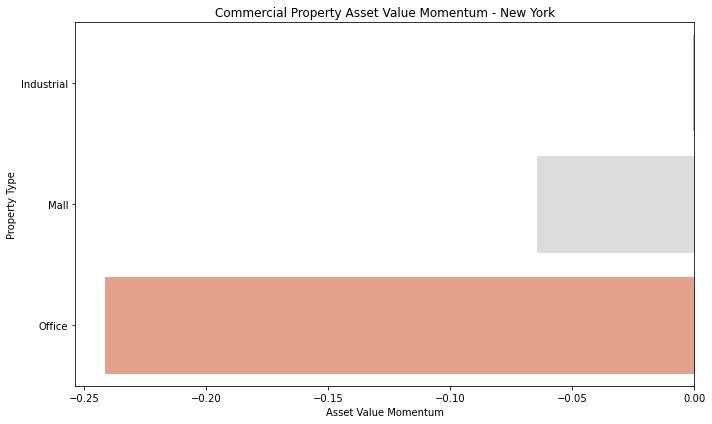

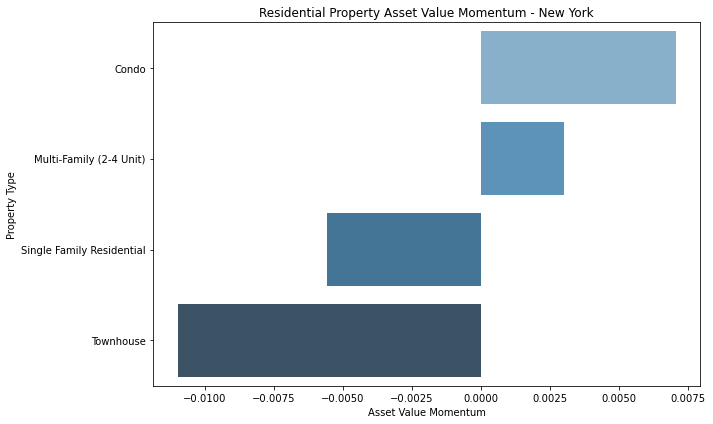

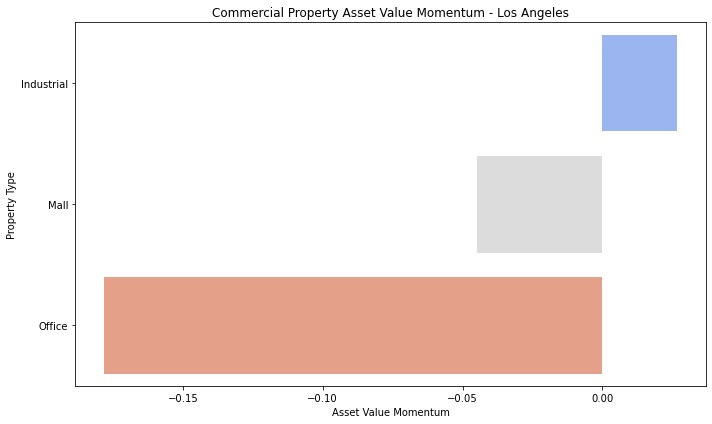

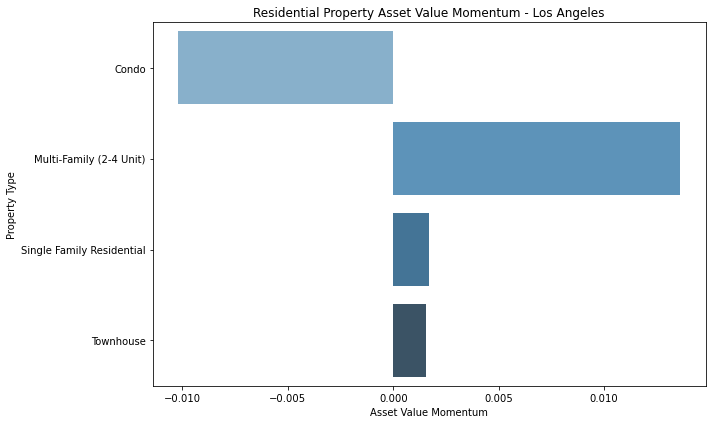

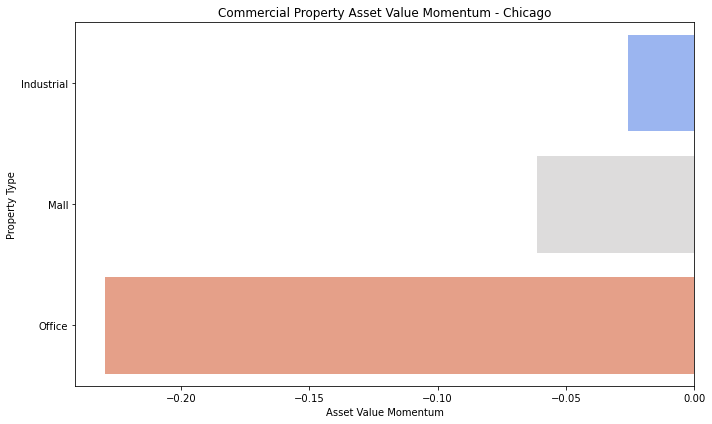

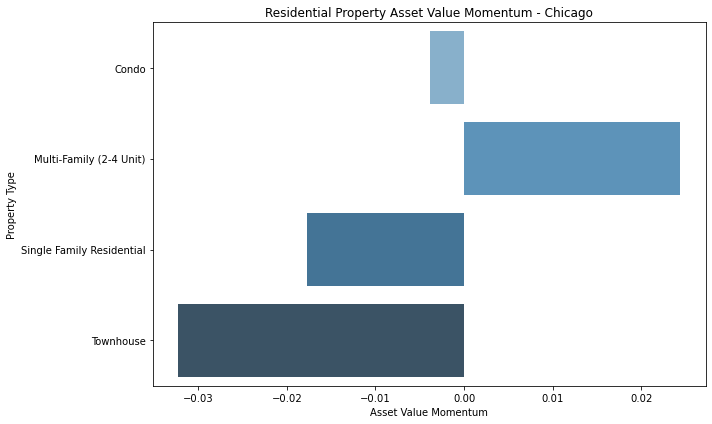

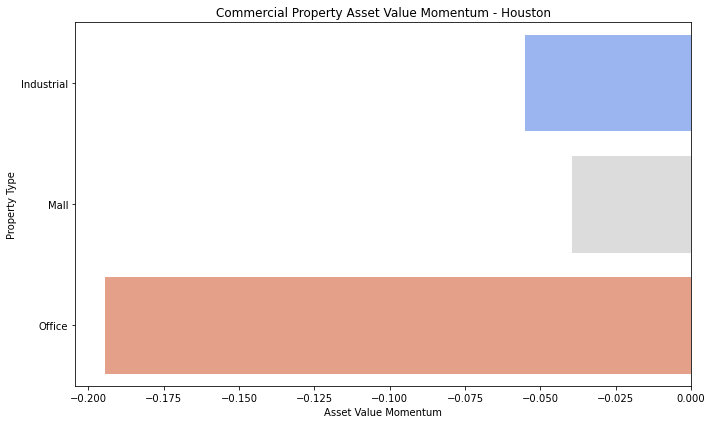

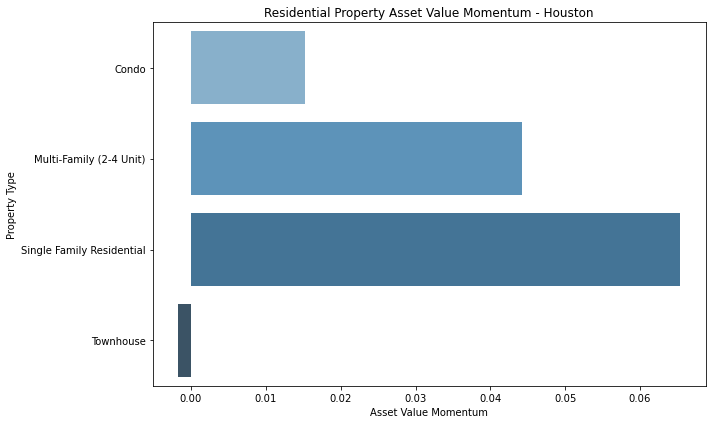

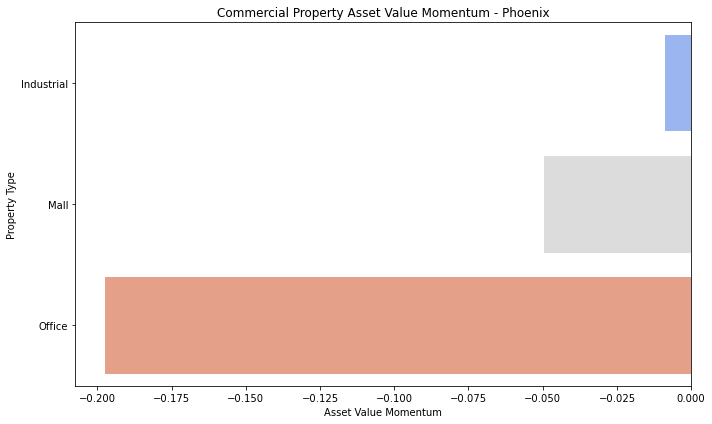

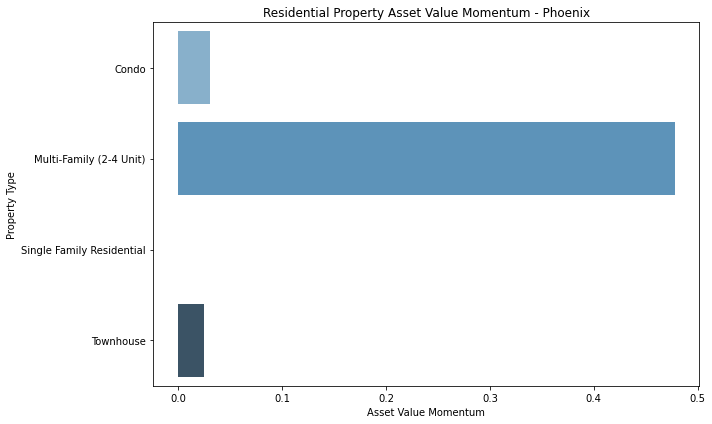

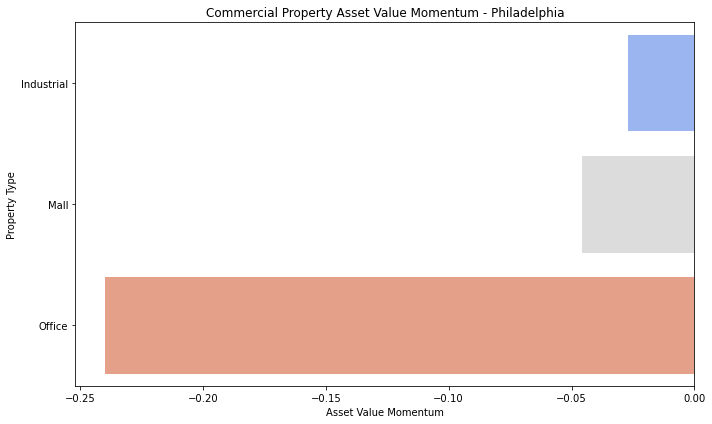

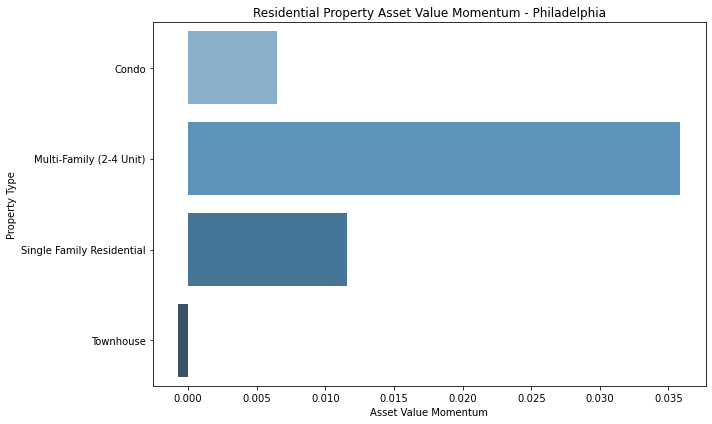

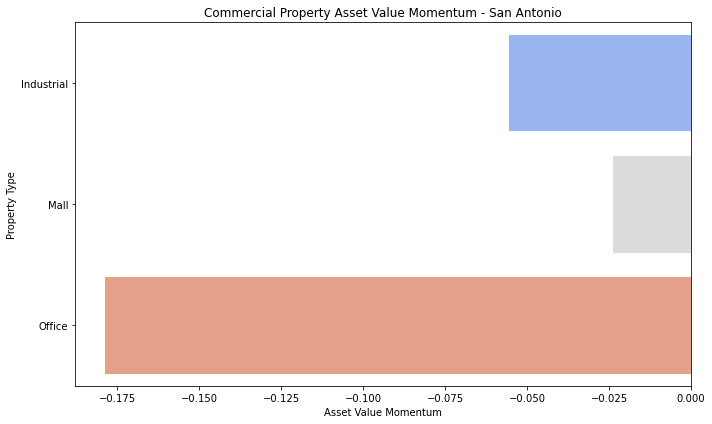

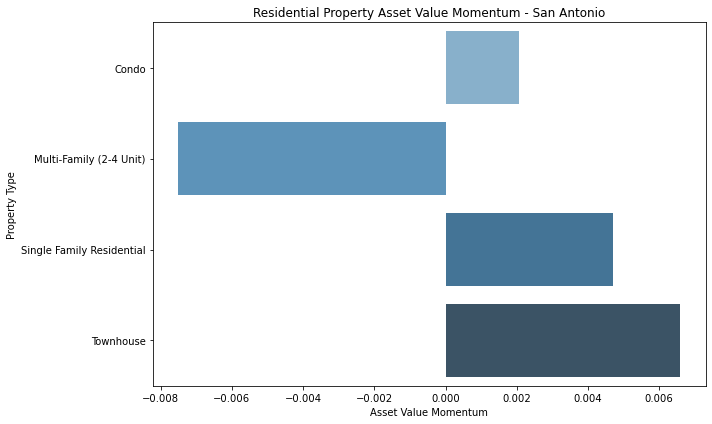

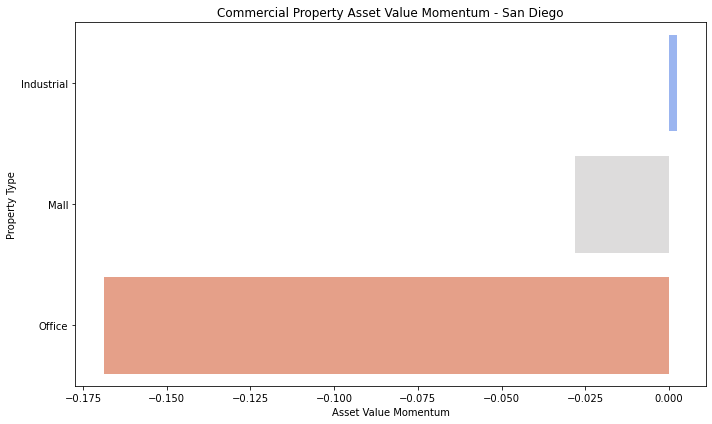

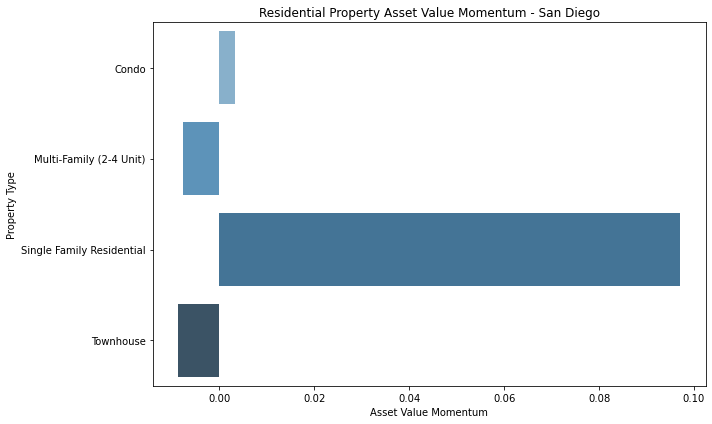

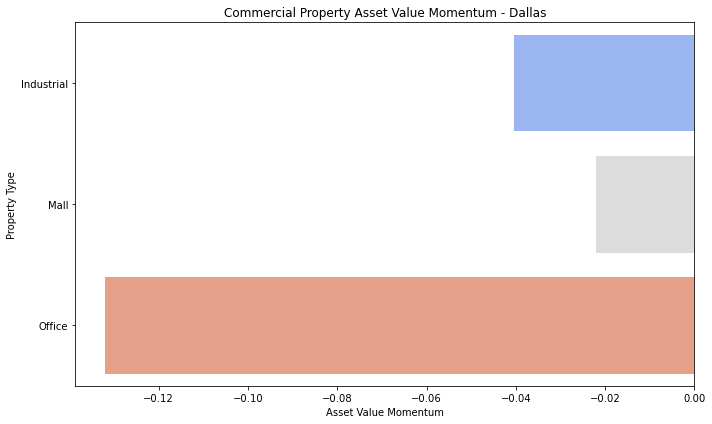

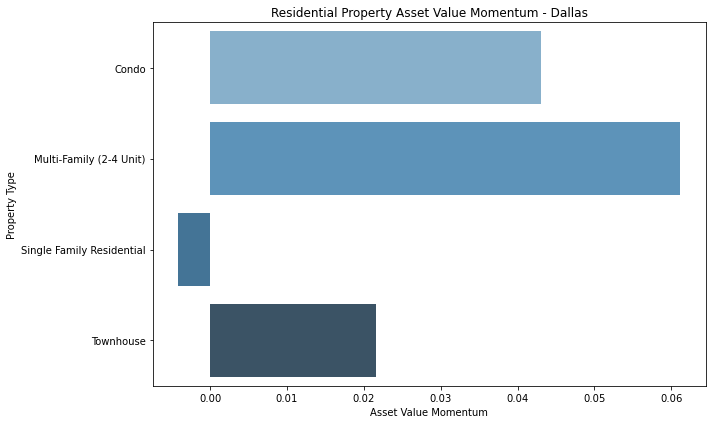

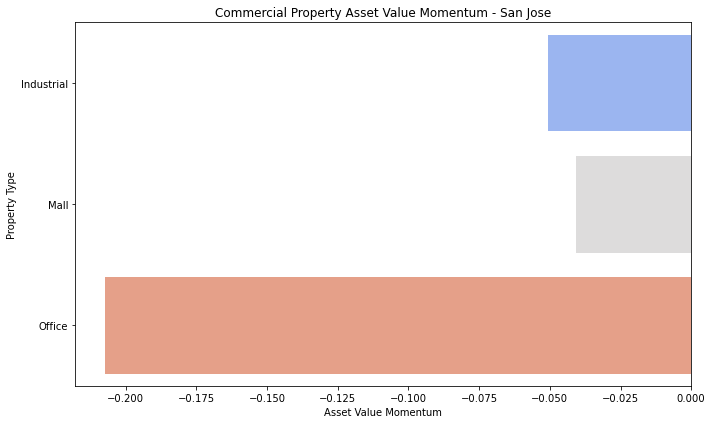

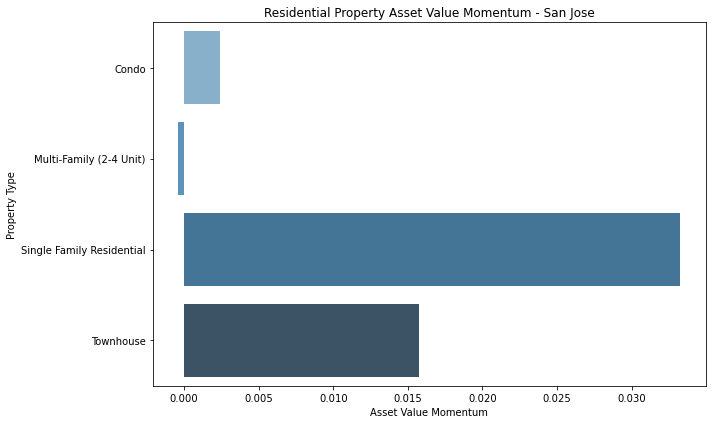

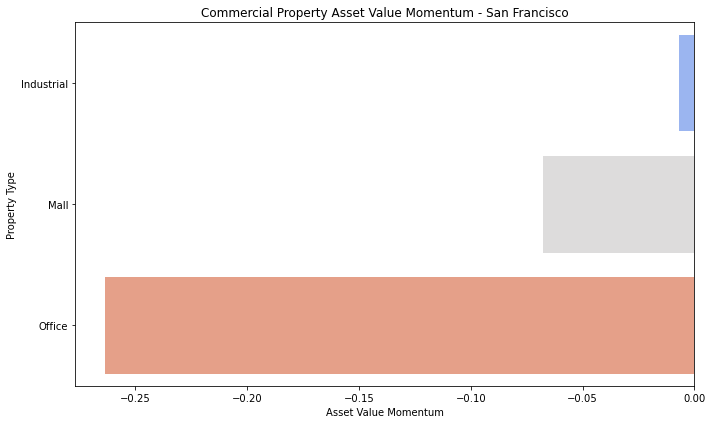

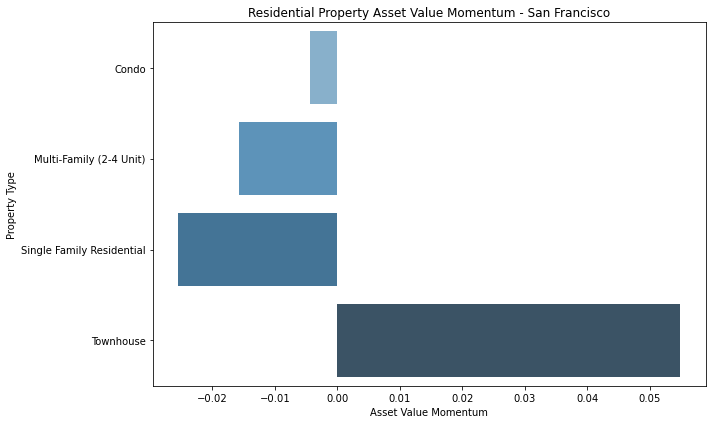

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


# Assuming the HousingData class is already defined
housing_data = HousingData('housing')

def analyze_city_for_types(city, df):
    """Analyze a city for both commercial and residential property types."""
    city_data = df[df['City'] == city]
    property_types = city_data['Property_Type'].unique()

    # Separate commercial and residential properties
    commercial_types = ['Mall', 'Office', 'Industrial']
    residential_types = [ptype for ptype in property_types if ptype not in commercial_types]

    # Analyze commercial properties
    commercial_data = city_data[city_data['Property_Type'].isin(commercial_types)]
    commercial_analysis = commercial_data.groupby('Property_Type').agg({
        'asset_value_momentum': 'mean',
        'occupancy': 'mean',
        'rank_desirability': 'mean'
    }).reset_index()

    # Analyze residential properties
    residential_data = city_data[city_data['Property_Type'].isin(residential_types)]
    residential_analysis = residential_data.groupby('Property_Type')['asset_value_momentum'].mean().reset_index()

    return commercial_analysis, residential_analysis

# Load data
housing_data = HousingData('housing')

all_data = housing_data.load_cleansed_data()

# List of top 10 US cities based on population for analysis
top_10_us_cities = ["New York", "Los Angeles", "Chicago", "Houston", "Phoenix", 
                    "Philadelphia", 'San Antonio', "San Diego", "Dallas", "San Jose", 'San Francisco']

# Dictionary to store analysis results for each city
city_analysis_results = {}

for city in top_10_us_cities:
    commercial_analysis, residential_analysis = analyze_city_for_types(city, all_data)
    city_analysis_results[city] = {
        'commercial_analysis': commercial_analysis,
        'residential_analysis': residential_analysis
    }

# Function to create formatted tables for commercial and residential analysis
def create_formatted_tables(city_analysis_dict):
    for city, analyses in city_analysis_dict.items():
        commercial_analysis = analyses['commercial_analysis']
        residential_analysis = analyses['residential_analysis']
        
        print(f"Commercial Property Analysis for {city}:")
        display(commercial_analysis.style.set_table_styles(
            [{'selector': 'th', 'props': [('font-size', '12pt')]}]
        ).background_gradient(cmap='viridis'))
        
        print(f"Residential Property Analysis for {city}:")
        display(residential_analysis.style.set_table_styles(
            [{'selector': 'th', 'props': [('font-size', '12pt')]}]
        ).background_gradient(cmap='viridis'))
        
        print("-" * 80)


# Function to create plots for the commercial and residential analysis
def create_plots(city_analysis_dict):
    for city, analyses in city_analysis_dict.items():
        commercial_analysis = analyses['commercial_analysis']
        residential_analysis = analyses['residential_analysis']
        
        # Plot for commercial properties
        if not commercial_analysis.empty:
            plt.figure(figsize=(10, 6))
            sns.barplot(data=commercial_analysis, x='asset_value_momentum', y='Property_Type', palette='coolwarm')
            plt.title(f"Commercial Property Asset Value Momentum - {city}")
            plt.xlabel("Asset Value Momentum")
            plt.ylabel("Property Type")
            plt.tight_layout()
            plt.show()

        # Plot for residential properties
        if not residential_analysis.empty:
            plt.figure(figsize=(10, 6))
            sns.barplot(data=residential_analysis, x='asset_value_momentum', y='Property_Type', palette='Blues_d')
            plt.title(f"Residential Property Asset Value Momentum - {city}")
            plt.xlabel("Asset Value Momentum")
            plt.ylabel("Property Type")
            plt.tight_layout()
            plt.show()

# Execute the analysis and display the formatted tables and plots
create_formatted_tables(city_analysis_results)
create_plots(city_analysis_results)


### Analyse de la Performance des Grandes Villes des États-Unis pour l'Investissement Immobilier

#### Propriétés Commerciales dans les Grandes Villes des États-Unis :

**Investir dans les Propriétés Industrielles :**
- **Los Angeles** présente une dynamique positive de la valeur de l'actif pour les propriétés industrielles, suggérant un potentiel d'appréciation de la valeur. Cette tendance positive contraste avec la plupart des autres villes, qui affichent une dynamique négative pour les propriétés commerciales.
- **New York et San Jose** montrent une dynamique négative significative pour les espaces de bureaux, indiquant la nécessité de la prudence sur ces marchés.

**Investissement Limité dans les Centres Commerciaux :**
- Les centres commerciaux dans toutes les villes connaissent une dynamique négative de la valeur de l'actif, avec la moins négative étant observée à **San Diego** et à **Dallas**. Malgré la tendance globale à la baisse, ces villes pourraient offrir des perspectives légèrement meilleures pour l'investissement dans les centres commerciaux.

**Observations sur les Espaces de Bureaux :**
- La tendance à la baisse de la dynamique des espaces de bureaux pourrait être attribuée au changement en cours dans les habitudes de travail, tel que l'augmentation du travail à distance, qui réduit la demande d'espaces de bureaux traditionnels.

#### Propriétés Résidentielles dans les Grandes Villes des États-Unis :

**Investir dans les Propriétés Résidentielles Individuelles :**
- **San Diego** se distingue par une dynamique notablement positive de la valeur de l'actif pour les propriétés résidentielles individuelles, suggérant un potentiel d'investissement significatif.
- **Philadelphie** présente une dynamique globalement positive pour différents types de propriétés résidentielles, indiquant une gamme diversifiée d'opportunités d'investissement résidentiel.

**Mises en Garde Contre l'Investissement Résidentiel dans Certaines Villes :**
- **San Antonio** présente une dynamique négative pour toutes les propriétés résidentielles, laissant entendre une possible diminution de la valeur immobilière.

**Investissement dans les Condos :**
- **Dallas** et **San Jose** affichent une dynamique positive pour les condos, indiquant que ces types de propriétés pourraient être de bonnes opportunités pour l'investissement résidentiel.

#### Considérations Stratégiques :

**Diversification :**
- Compte tenu des performances variables des types de biens immobiliers et des villes, les investisseurs devraient envisager de diversifier leurs portefeuilles pour répartir les risques.

**Suivi des Tendances du Marché :**
- Surtout pour les propriétés commerciales, les investisseurs doivent rester informés des tendances économiques et sociales susceptibles d'influencer les valeurs immobilières et les taux d'occupation.

**Dynamique du Marché Local :**
- Les conditions du marché local peuvent varier considérablement, même dans le cadre des tendances plus larges. Une recherche approfondie sur la dynamique du marché local est essentielle pour prendre des décisions d'investissement éclairées.

#### Facteurs Supplémentaires pour les Décisions d'Investissement :
- La croissance économique locale, les plans de développement urbain et les changements démographiques doivent également être pris en compte lors de la prise de décisions d'investissement. Bien que la dynamique de la valeur de l'actif fournisse des informations précieuses, une analyse complète incluant ces facteurs conduira à une stratégie d'investissement plus solide.

### Conclusion :

Cette analyse mise à jour présente une vision nuancée du paysage de l'investissement dans les grandes villes des États-Unis. Les investisseurs devraient se concentrer sur les marchés présentant une dynamique positive ou la moins négative pour les propriétés commerciales et sur des indicateurs de croissance solides pour les investissements résidentiels. Il est nécessaire de tenir compte du potentiel de continuité des tendances du travail à distance dans la demande d'espaces de bureau lors de la prise de décisions d'investissement. Des révisions régulières du marché et des ajustements de stratégie sont recommandés pour naviguer efficacement dans le marché immobilier dynamique.

### Résumé Détaillé : Stratégies d'Investissement Immobilier pour 2024 et 2025

#### Perspectives d'Investissement :
Notre analyse révisée a révélé des opportunités d'investissement distinctes entre les propriétés commerciales et résidentielles pour 2024 et 2025. 

#### Quoi acheter ou vendre :

**Immobilier Commercial :**
- **Acheter** : Les investissements dans les propriétés industrielles de Jersey City sont prometteurs, montrant une dynamique positive. Les centres commerciaux de certaines villes, comme Dallas, offrent un risque plus faible et un potentiel de stabilité.
- **Vendre** : Les propriétés de bureaux et industrielles dans des villes comme New York et San Jose sont conseillées à la vente en 2024 en raison de la forte dépréciation attendue.

**Immobilier Résidentiel :**
- **Acheter** : Burlington et Richmond se démarquent pour l'investissement résidentiel, montrant une forte dynamique positive. 
- **Vendre** : Les propriétés dans des villes comme Middletown et San Antonio, où une baisse notable de l'élan est observée, devraient être vendues avant 2025.

#### Où acheter ou vendre :

**Dans les Grandes Villes :**
- Investir dans des villes économiquement robustes comme Los Angeles pour les propriétés industrielles et San Diego pour les propriétés résidentielles.
- Éviter les investissements commerciaux dans des villes comme Philadelphia et Minneapolis en raison d'un élan négatif significatif.

#### Quand acheter ou vendre :

- **Acheter en 2024** : La fenêtre d'opportunité est optimale en 2024 pour les propriétés commerciales et résidentielles à fort élan positif.
- **Vendre avant 2025** : La vente est conseillée avant 2025 pour les types de propriétés montrant une diminution significative de l'élan.

#### Méthodologie :

1. **Agrégation des Données** : Analyse des données immobilières en se concentrant sur l'élan de la valeur de l'actif.
2. **Analyse des Tendances** : Identification des propriétés avec un élan positif ou négatif en fonction de critères tels que l'occupation et la désirabilité.
3. **Évaluation par Ville** : Analyse comparative des villes pour identifier les meilleures opportunités d'investissement.
4. **Comparaison Annuelle et de Magnitude du Changement** : Évaluation de l'amplitude du changement pour guider les décisions de vente.

#### Synthèse des Recommandations :

**Pour les Propriétés Commerciales :**
- Focus sur l'achat dans des villes avec des indicateurs de stabilité comme Jersey City et Dallas.
- Préparer la vente de propriétés de bureaux et industrielles en 2024 pour anticiper les tendances négatives.

**Pour les Propriétés Résidentielles :**
- Cibler des villes en croissance comme Burlington et Richmond pour des achats en 2024.
- Planifier la vente dans des villes avec un élan résidentiel déclinant comme Middletown et San Antonio avant 2025.

#### Conclusion et Mise en Œuvre Stratégique :

Les investisseurs doivent adopter une approche nuancée, en tenant compte des distinctions entre les propriétés commerciales et résidentielles et en se basant sur des analyses de données avancées pour prendre des décisions éclairées. Il est crucial de surveiller les tendances, d'agir sur des indicateurs fiables d'achat et de vente, et de réviser régulièrement les stratégies d'investissement pour rester alignés avec les dynamiques changeantes du marché immobilier. Notre analyse mise à jour vise à fournir une feuille de route pour maximiser les retours sur

 investissement et minimiser les risques dans les années à venir.

### Analyse de Suivi: Impact du Travail à Distance sur les Recommandations en Matière d'Investissement

#### Objectif :
Cette section est dédiée à évaluer l'influence significative que la tendance croissante du travail à distance a eue sur les décisions d'investissement immobilier, en s'appuyant sur les tendances observées de 2019 à 2023. Notre analyse se concentre sur l'identification des meilleures villes et des types de propriétés pour les investissements futurs, guidée par les prévisions générées par les modèles RNN pour 2024 et 2025.

#### Méthodologie :
1. **Segmentation des Données par Année**: Nous segmenterons les données en périodes clés pour examiner l'évolution des tendances du travail à distance par rapport à l'élan de la valeur des biens immobiliers.

2. **Analyse de la Part du Travail à Distance Prévue**: En utilisant les données prédites par les RNN, nous évaluerons la part du travail à distance pour 2024 et 2025 dans différentes villes.

3. **Analyse Annuelle des Meilleures Villes et Types de Propriétés**:
   - **Meilleures Villes et Types de Propriétés**: Sur la base de l'élan de la valeur des biens immobiliers prédit par les RNN, nous identifierons les villes et les types de propriétés les plus avantageux pour les années 2024 et 2025.
   - **Mise au Point sur les Grandes Villes Américaines**: Nous porterons une attention particulière aux grandes villes américaines pour évaluer leur adaptabilité aux changements induits par le travail à distance.

4. **Comparaison des Constatations**:
   - **Changements Année après Année**: Nous comparerons les données annuelles pour comprendre comment les tendances de travail à distance ont influencé le marché immobilier au fil du temps.

#### Importance de l'Analyse :
Cette analyse fournit des informations essentielles pour comprendre comment les tendances du travail à distance redéfinissent les opportunités d'investissement immobilier, affiner les stratégies d'investissement pour s'aligner sur une culture de travail en mutation et préparer les investisseurs à tirer parti des tendances émergentes.

Nous entamerons notre analyse par:

1. **Visualisation des Données Prédites**: Créer des visualisations des données prédites pour illustrer les tendances et éclairer les stratégies d'investissement.

2. **Synthèse des Recommandations**: Utiliser les prévisions pour formuler des recommandations d'achat ou de vente pour les types de propriétés et les villes sélectionnées.

### Conclusion :
L'analyse finalisée offrira une vue clairvoyante sur l'impact du travail à distance sur le marché immobilier et sur la manière dont les investisseurs peuvent optimiser leurs stratégies d'investissement pour les années 2024 et 2025. Les données prédictives issues des RNN seront un socle essentiel pour cette analyse, fournissant un aperçu précieux des tendances futures et aidant à aligner les décisions d'investissement avec les évolutions du marché. Nous utiliserons ces prédictions pour identifier des opportunités d'investissement stratégiques, en tirant parti des dynamiques de marché changeantes et en anticipant les besoins futurs induits par le travail à distance.

In [39]:
import pandas as pd

# Loading the data
housing_data = HousingData('housing')
all_data = housing_data.load_cleansed_data()

# Define the date ranges for the different periods
date_ranges = {
    "pre_covid": ("2019-01-01", "2020-02-29"),
    "covid_lockdown": ("2020-03-01", "2021-12-31"),
    "post_lockdown": ("2022-01-01", "2022-12-31"),
    "recent_phase": ("2023-01-01", "2023-12-31")
}

# Function to segment the data according to the defined periods
def segment_data(df, date_ranges):
    segmented_data = {}
    for phase, (start_date, end_date) in date_ranges.items():
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        segmented_data[phase] = df[(df['period_begin'] >= start_date) & (df['period_begin'] <= end_date)]
    return segmented_data

# Implement the data segmentation
segmented_data = segment_data(all_data, date_ranges)

# Function to extract forecasted data for multiple property types and a given start date
def extract_forecasted_data(df, property_types, forecast_start_date):
    forecasted_dfs = []
    for property_type in property_types:
        forecasted_df = df[(df['Property_Type'] == property_type) & (df['period_begin'] >= forecast_start_date)]
        forecasted_dfs.append(forecasted_df)
    return pd.concat(forecasted_dfs)

# Define the forecasting period start date for both commercial and residential properties
forecast_start_date = pd.to_datetime('2024-01-31')

# Extract forecasted data for both commercial and residential properties
property_types = ['Mall', 'Office', 'Industrial', 'Condo', 'Townhouse', 'Single Family Residential', 'Multi-Family (2-4 Unit)']
forecasted_data = extract_forecasted_data(all_data, property_types, forecast_start_date)
for property_type in property_types:
    forecasted_data_temp = extract_forecasted_data(all_data, property_type, forecast_start_date)
    forecasted_data = forecasted_data.append(forecasted_data_temp)



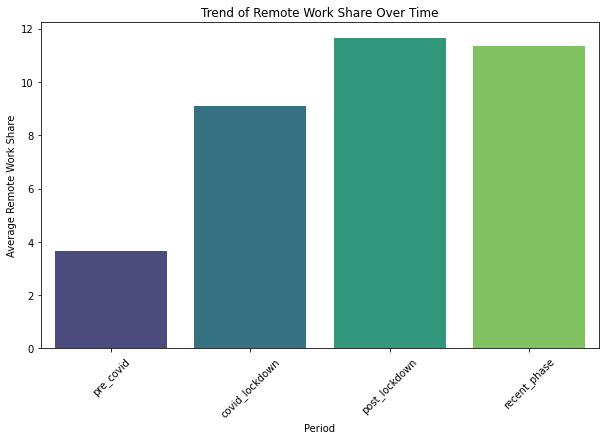

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate the average remote work share for each period
def calculate_remote_work_share(segmented_data):
    remote_work_share_by_period = {}
    for period, data in segmented_data.items():
        average_share = data['remote_work_share'].mean()
        remote_work_share_by_period[period] = average_share
    return remote_work_share_by_period

# Calculate the remote work share for each segmented period
remote_work_shares = calculate_remote_work_share(segmented_data)

# Visualization of Remote Work Share Trends
def visualize_remote_work_share(remote_work_shares):
    periods = list(remote_work_shares.keys())
    shares = list(remote_work_shares.values())

    plt.figure(figsize=(10, 6))
    sns.barplot(x=periods, y=shares, palette='viridis')
    plt.title('Trend of Remote Work Share Over Time')
    plt.xlabel('Period')
    plt.ylabel('Average Remote Work Share')
    plt.xticks(rotation=45)
    plt.show()

# Visualizing the trend of remote work share
visualize_remote_work_share(remote_work_shares)


In [41]:
# Function to find top cities and property types based on asset value momentum for each year
def identify_top_cities_and_properties(segmented_data, forecasted_data):
    top_cities_properties = {}

    # Combine historical and forecasted data for analysis
    combined_data = pd.concat([segmented_data['pre_covid'], segmented_data['covid_lockdown'], 
                               segmented_data['post_lockdown'], segmented_data['recent_phase'], forecasted_data])

    # Analyze for each year
    for year in combined_data['period_begin'].dt.year.unique():
        yearly_data = combined_data[combined_data['period_begin'].dt.year == year]
        top_cities = yearly_data.groupby('City')['asset_value_momentum'].mean().sort_values(ascending=False).head(10).index.tolist()
        top_properties = yearly_data.groupby('Property_Type')['asset_value_momentum'].mean().sort_values(ascending=False).head(10).index.tolist()
        top_cities_properties[year] = {'Top Cities': top_cities, 'Top Properties': top_properties}

    return top_cities_properties

# Function to analyze major American cities segmented by periods
def analyze_major_american_cities_by_periods(segmented_data, major_cities):
    city_analysis_by_period = {}

    for period, data in segmented_data.items():
        city_analysis = {}
        for city in major_cities:
            city_data = data[data['City'] == city]

            # Calculate average remote work share and asset value momentum for the city
            avg_remote_work_share = city_data['remote_work_share'].mean()
            avg_asset_value_momentum = city_data['asset_value_momentum'].mean()

            # Calculate average asset value momentum per property type for the city
            avg_momentum_per_property_type = city_data.groupby('Property_Type')['asset_value_momentum'].mean().to_dict()

            city_analysis[city] = {
                'Average Remote Work Share': avg_remote_work_share, 
                'Average Asset Value Momentum': avg_asset_value_momentum,
                'Avg Asset Value Momentum by Property Type': avg_momentum_per_property_type
            }
        city_analysis_by_period[period] = city_analysis

    return city_analysis_by_period

# Define major American cities
major_cities = ["New York", "Los Angeles", "Chicago", "Houston", "Phoenix", 
                "Philadelphia", "San Antonio", "San Diego", "Dallas", "San Jose", "San Francisco"]

# Identify top cities and properties
top_cities_properties = identify_top_cities_and_properties(segmented_data, forecasted_data)

# Analyze major American cities by periods with property type analysis
major_city_analysis_by_periods = analyze_major_american_cities_by_periods(segmented_data, major_cities)


In [42]:
import pandas as pd

# Function to compare year-over-year data
def compare_yearly_data(segmented_data, forecasted_data):
    yearly_comparison = {}
    combined_data = pd.concat([data for data in segmented_data.values()] + [forecasted_data])

    for year in range(2019, 2026):  # Analyzing data from 2019 to 2025
        if year == 2019:
            continue  # Skip 2019 as there's no previous year data
        current_year_data = combined_data[combined_data['period_begin'].dt.year == year]
        previous_year_data = combined_data[combined_data['period_begin'].dt.year == (year - 1)]

        # Calculate yearly change in asset value momentum
        avg_momentum_current = current_year_data['asset_value_momentum'].mean()
        avg_momentum_previous = previous_year_data['asset_value_momentum'].mean()
        momentum_change = avg_momentum_current - avg_momentum_previous

        yearly_comparison[year] = {'Average Asset Value Momentum Change': momentum_change}

    return yearly_comparison

# Function to assess the impact of remote work on the real estate market
def assess_impact_of_remote_work(segmented_data, forecasted_data):
    impact_assessment = {}
    combined_data = pd.concat([data for data in segmented_data.values()] + [forecasted_data])

    for year in range(2019, 2026):
        year_data = combined_data[combined_data['period_begin'].dt.year == year]

        # Calculate average remote work share and asset value momentum
        avg_remote_work_share = year_data['remote_work_share'].mean()
        avg_asset_value_momentum = year_data['asset_value_momentum'].mean()

        impact_assessment[year] = {'Average Remote Work Share': avg_remote_work_share,
                                   'Average Asset Value Momentum': avg_asset_value_momentum}

    return impact_assessment

# Implementing the data segmentation and forecasted data loading as in Section 1
segmented_data = segment_data(all_data, date_ranges)  # Assuming all_data and date_ranges are already defined
forecasted_data = extract_forecasted_data(all_data, property_types, forecast_start_date)  # Assuming property_types and forecast_start_date are already defined

# Perform yearly data comparison
yearly_data_comparison = compare_yearly_data(segmented_data, forecasted_data)

# Perform impact assessment of remote work
remote_work_impact_assessment = assess_impact_of_remote_work(segmented_data, forecasted_data)


In [43]:
import pandas as pd

# Assuming 'segmented_data' is already defined and contains the segmented historical data

# Function to calculate the average remote work share for each period
def calculate_remote_work_share(segmented_data):
    remote_work_share_summary = pd.DataFrame(columns=['Period', 'Average Remote Work Share'])
    for period, data in segmented_data.items():
        average_share = data['remote_work_share'].mean()
        remote_work_share_summary = remote_work_share_summary.append({'Period': period, 'Average Remote Work Share': average_share}, ignore_index=True)
    return remote_work_share_summary

# Calculate and display the remote work share summary
remote_work_share_summary = calculate_remote_work_share(segmented_data)
remote_work_share_summary

,Period,Average Remote Work Share
0,pre_covid,3.666673
1,covid_lockdown,9.114493
2,post_lockdown,11.652331
3,recent_phase,11.337011


In [44]:
# Assuming 'segmented_data' and 'forecasted_data' are already defined

# Function to analyze the impact of remote work on asset value momentum
def analyze_remote_work_impact(segmented_data, forecasted_data):
    impact_analysis = pd.DataFrame(columns=['Period', 'Property Type', 'Average Asset Value Momentum'])
    
    # Combine historical and forecasted data for analysis
    combined_data = pd.concat([data for data in segmented_data.values()] + [forecasted_data])

    for period, data in segmented_data.items():
        for property_type in combined_data['Property_Type'].unique():
            property_data = data[data['Property_Type'] == property_type]
            avg_momentum = property_data['asset_value_momentum'].mean()
            impact_analysis = impact_analysis.append({'Period': period, 'Property Type': property_type, 'Average Asset Value Momentum': avg_momentum}, ignore_index=True)
    
    return impact_analysis

# Analyze the impact of remote work on real estate market
remote_work_impact_analysis = analyze_remote_work_impact(segmented_data, forecasted_data)
remote_work_impact_analysis


,Period,Property Type,Average Asset Value Momentum
0,pre_covid,Single Family Residential,0.254737
1,pre_covid,Multi-Family (2-4 Unit),0.085437
2,pre_covid,Condo,0.093793
3,pre_covid,Townhouse,0.030602
4,pre_covid,Office,0.033958
5,pre_covid,Mall,-0.000698
6,pre_covid,Industrial,0.088634
7,covid_lockdown,Single Family Residential,0.020886
8,covid_lockdown,Multi-Family (2-4 Unit),0.313867
9,covid_lockdown,Condo,0.032505


In [45]:
# function to display each top property type and its momentum on separate lines
def synthesize_insights(remote_work_share_summary, remote_work_impact_analysis):
    revised_report = pd.DataFrame(columns=['Period', 'Remote Work Share', 'Top Property Type 1', 'Momentum 1', 'Top Property Type 2', 'Momentum 2', 'Top Property Type 3', 'Momentum 3'])

    for period in remote_work_share_summary['Period']:
        remote_work_share = remote_work_share_summary[remote_work_share_summary['Period'] == period]['Average Remote Work Share'].values[0]
        momentum_data = remote_work_impact_analysis[remote_work_impact_analysis['Period'] == period]
        
        # Getting top 3 performing property types for the period
        top_properties = momentum_data.sort_values(by='Average Asset Value Momentum', ascending=False).head(3)
        
        # Extracting top property types and their momentums
        top_properties_list = top_properties[['Property Type', 'Average Asset Value Momentum']].values

        # Creating a dictionary to hold the top property types and their momentums
        top_properties_dict = {}
        for i, (ptype, momentum) in enumerate(top_properties_list, start=1):
            top_properties_dict[f'Top Property Type {i}'] = ptype
            top_properties_dict[f'Momentum {i}'] = f"{momentum:.2f}"

        revised_report = revised_report.append({
            'Period': period, 
            'Remote Work Share': f"{remote_work_share:.2f}",
            **top_properties_dict
        }, ignore_index=True)

    return revised_report

# Generate the revised enhanced report
synthesized_report = synthesize_insights(remote_work_share_summary, remote_work_impact_analysis)
synthesized_report


,Period,Remote Work Share,Top Property Type 1,Momentum 1,Top Property Type 2,Momentum 2,Top Property Type 3,Momentum 3
0,pre_covid,3.67,Single Family Residential,0.25,Condo,0.09,Industrial,0.09
1,covid_lockdown,9.11,Multi-Family (2-4 Unit),0.31,Industrial,0.14,Townhouse,0.04
2,post_lockdown,11.65,Mall,0.19,Industrial,0.17,Condo,0.14
3,recent_phase,11.34,Multi-Family (2-4 Unit),0.10,Condo,0.05,Townhouse,0.02


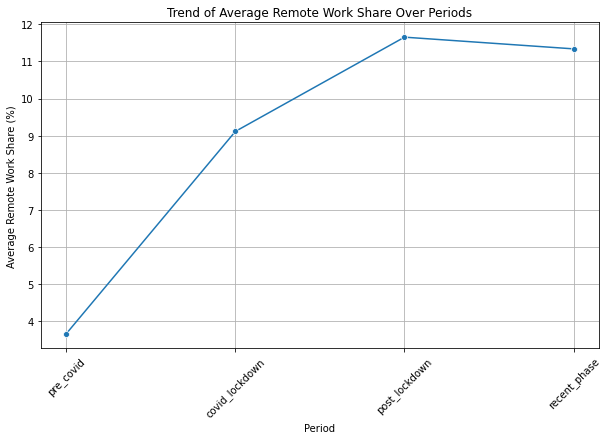

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'remote_work_share_summary' is already defined
plt.figure(figsize=(10, 6))
sns.lineplot(x='Period', y='Average Remote Work Share', data=remote_work_share_summary, marker='o')
plt.title('Trend of Average Remote Work Share Over Periods')
plt.xlabel('Period')
plt.ylabel('Average Remote Work Share (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


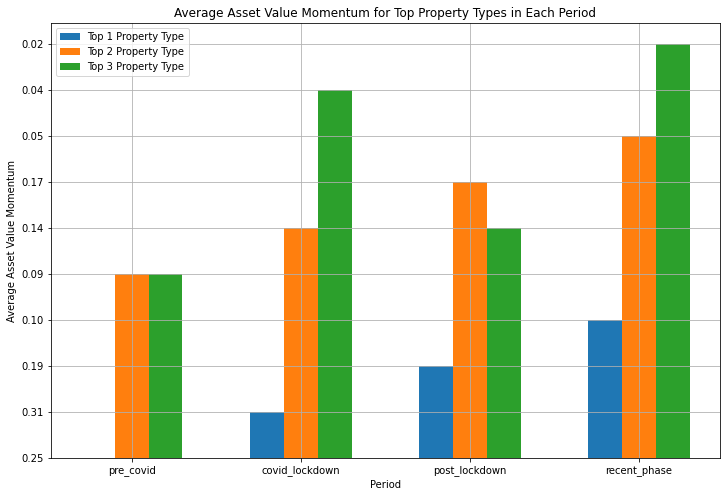

In [47]:
plt.figure(figsize=(12, 8))
bar_width = 0.2
periods = synthesized_report['Period'].unique()  # Unique periods
bar_positions = range(len(periods))  # Corresponding positions for the bars

# Plotting each property type's momentum for each period
for i in range(1, 4):
    # Get the momentum for the ith top property type across all periods
    momentums = [synthesized_report[synthesized_report['Period'] == period][f'Momentum {i}'].values[0] for period in periods]
    plt.bar([x + (i-1)*bar_width for x in bar_positions], momentums, width=bar_width, label=f'Top {i} Property Type')

plt.xlabel('Period')
plt.ylabel('Average Asset Value Momentum')
plt.title('Average Asset Value Momentum for Top Property Types in Each Period')
plt.xticks([r + bar_width for r in bar_positions], periods)
plt.legend()
plt.grid(True)
plt.show()


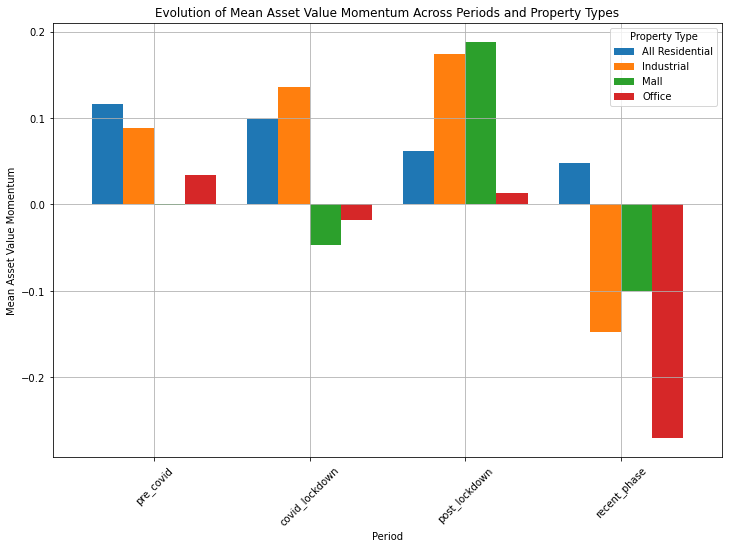

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'all_data' is your DataFrame containing the relevant information
# Ensure it has columns 'period_begin', 'Property_Type', and 'asset_value_momentum'

# Define the date ranges for the different periods
date_ranges = {
    "pre_covid": ("2019-01-01", "2020-02-29"),
    "covid_lockdown": ("2020-03-01", "2021-12-31"),
    "post_lockdown": ("2022-01-01", "2022-12-31"),
    "recent_phase": ("2023-01-01", "2023-08-31")
}

# Function to segment the data according to the defined periods
def segment_data(df, date_ranges):
    segmented_data = {}
    for phase, (start_date, end_date) in date_ranges.items():
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        segmented_data[phase] = df[(df['period_begin'] >= start_date) & (df['period_begin'] <= end_date)]
    return segmented_data

# Implement the data segmentation
segmented_data = segment_data(all_data, date_ranges)

# Function to aggregate 'All Residential' property types
def aggregate_residential(df):
    residential_types = ['Condo', 'Townhouse', 'Single Family Residential', 'Multi-Family (2-4 Unit)']
    df_residential = df[df['Property_Type'].isin(residential_types)].copy()
    df_residential['Property_Type'] = 'All Residential'
    return df_residential.groupby(['period_begin']).mean().reset_index()

# Function to calculate the mean asset value momentum for each period and property type
def calculate_mean_momentum(segmented_data, property_types):
    mean_momentum = pd.DataFrame()
    for period, data in segmented_data.items():
        period_data = pd.DataFrame()
        for property_type in property_types:
            if property_type == 'All Residential':
                property_data = aggregate_residential(data)
            else:
                property_data = data[data['Property_Type'] == property_type]

            mean_momentum_value = property_data['asset_value_momentum'].mean()
            period_data = period_data.append({'Period': period, 'Property Type': property_type, 
                                              'Mean Asset Value Momentum': mean_momentum_value}, ignore_index=True)

        mean_momentum = pd.concat([mean_momentum, period_data])
    return mean_momentum

# Define property types to analyze, including 'All Residential'
property_types = ['Mall', 'Office', 'Industrial', 'All Residential']

# Calculate mean asset value momentum for each period and property type
mean_momentum_data = calculate_mean_momentum(segmented_data, property_types)

# Pivot the data for plotting
pivot_data = mean_momentum_data.pivot(index='Period', columns='Property Type', values='Mean Asset Value Momentum').reindex(['pre_covid', 'covid_lockdown', 'post_lockdown', 'recent_phase'])

# Plotting
plt.figure(figsize=(12, 8))
pivot_data.plot(kind='bar', width=0.8, ax=plt.gca())
plt.xlabel('Period')
plt.ylabel('Mean Asset Value Momentum')
plt.title('Evolution of Mean Asset Value Momentum Across Periods and Property Types')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Property Type')
plt.show()


### Importance du Travail à Distance dans la Performance des Classes d'Actifs et Recommandations Futures

L'essor du travail à distance a significativement impacté le marché immobilier. Notre analyse se concentre sur la compréhension de cet impact et son utilisation pour orienter les recommandations d'investissement pour les différentes classes d'actifs. Voici une synthèse de nos conclusions et de la manière dont le travail à distance façonne nos stratégies :

#### Tendances du Travail à Distance
La segmentation des données montre une augmentation substantielle de la part du travail à distance depuis la période pré-COVID jusqu'à la phase récente. Notamment, la période de confinement a accéléré cette tendance, et des niveaux élevés ont persisté après le déconfinement, indiquant un changement potentiel à long terme dans les modes de travail.

#### Impact sur les Classes d'Actifs
La performance des différentes classes d'actifs immobiliers a varié au fil du temps, avec des corrélations notables avec les tendances du travail à distance :

- **Propriétés Résidentielles** : Les maisons individuelles et les propriétés résidentielles ont connu une demande constante, probablement due au besoin d'avoir plus d'espace et de confort alors que les gens passent plus de temps à la maison.
- **Propriétés Commerciales** : La demande pour des propriétés commerciales comme les bureaux a diminué, reflétant le passage à des modèles de travail à distance et hybrides.

#### Analyse par Période et Momentum des Actifs
Notre analyse des différentes périodes pré-COVID et post-COVID révèle un schéma clair :

- Pendant le **confinement**, les propriétés **Multi-Family (2-4 Unit)** ont vu leur momentum augmenter fortement, probablement en raison de l'attrait des espaces partagés et des équipements à une époque où les installations publiques étaient inaccessibles.
- Dans la phase **post-confinement**, nous avons observé une augmentation inattendue du momentum des **Malls**, suggérant un possible rebond ou une correction après une période de déclin.
- La **phase récente** montre un retour en faveur des propriétés **Résidentielles Individuelles**, renforçant la tendance vers l'espace personnel et l'investissement dans le logement.

#### Corrélation avec la Part du Travail à Distance

Les données suggèrent que plus la part du travail à distance augmente, plus cela a d'influence sur les valeurs immobilières. La corrélation se déroule comme suit :

- **Pré-COVID** : Une faible part du travail à distance n'a pas perturbé de manière significative la performance des classes d'actifs traditionnelles.
- **Confinement COVID** : L'augmentation de la part du travail à distance s'est alignée directement avec un changement de momentum en faveur des propriétés résidentielles et en défaveur des espaces commerciaux.
- **Post-Confinement** : La part élevée et maintenue du travail à distance a maintenu le momentum modifié, avec une augmentation notable de la valeur des propriétés de centre commercial.
- **Phase Récente** : La stabilisation de la part du travail à distance continue de montrer une préférence pour les propriétés résidentielles, en particulier les maisons individuelles.

#### Conclusions et Recommandations d'Investissement

**Immobilier Résidentiel** :
- **Acheter** : Les maisons individuelles et les propriétés résidentielles, avec un momentum de valeur cohérent, sont recommandées à l'achat, en particulier dans les zones adaptées au travail à distance.
- **Vendre** : Les unités multi-familiales pourraient être envisagées à la vente dans les régions où le travail à distance diminue ou se stabilise.

**Immobilier Commercial** :
- **Acheter** : Des investissements ciblés dans les propriétés commerciales, comme les centres commerciaux dans les villes ayant montré un rebond, peuvent être envisagés, en se concentrant sur des propriétés adaptées aux nouvelles dynamiques du marché.
- **Vendre** : Les espaces de bureaux, surtout dans les zones urbaines à forte densité qui n'ont pas adopté des modèles de

 travail hybrides, pourraient être envisagés pour la vente.

### Conclusion

Le paysage immobilier a été remodelé par l'émergence et la consolidation des tendances du travail à distance. Cette évolution a impacté différemment les différentes classes d'actifs, présentant des défis et des opportunités pour les investisseurs. La solidité des propriétés résidentielles, en termes de momentum de la valeur, suggère des opportunités d'investissement solides, tandis que les propriétés commerciales nécessitent une approche plus nuancée et adaptative. En tenant compte des tendances et des modèles identifiés, les investisseurs peuvent prendre des décisions éclairées qui s'alignent sur la trajectoire changeante du marché immobilier.